## Importing the Libraries

We will start by importing the libraries and setting some parameters for the whole notebook(such as parameters for plots etc.).

In [353]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
np.random.seed(42)
import pandas as pd
pd.set_option('display.max_columns',None) #Displaying all the columns

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' #To display the graphs clearly

import seaborn as sns
sns.set_style('darkgrid')

#Setting up the parameters
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

## Getting the Data

The data is in .xlsx format, it will be read and then split into train and test sets with a 80:20 ratio. The training set will be used for exploratory data analysis to gather insights from the data and know it well in order to take the necessary steps to pre-process it, and then it will be fed into the machine learning models to train them. The models will then be evaluated on the test data.

In [354]:
df = pd.read_excel('pone.0216972.s001.xlsx')
print('DataFrame Loaded successfully!')
print("The Dataset contains {} rows and {} columns".format(df.shape[0],df.shape[1]))

DataFrame Loaded successfully!
The Dataset contains 1267 rows and 24 columns


In [355]:
#Splitting the data into train and test sets
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.2,random_state=42,stratify=df['KTAS_expert'])

print("DataFrames Split Successfully!")
print("The train set contains {} rows and {} columns".format(train_df.shape[0], train_df.shape[1]))
print("The test set contains {} rows and {} columns".format(test_df.shape[0], test_df.shape[1]))

DataFrames Split Successfully!
The train set contains 1013 rows and 24 columns
The test set contains 254 rows and 24 columns


## A Quick Look at our Data

The aim of this section is to familiarize ourselves with the data. We will focus entirely on the **training set** and forget about the test set completely (this is to prevent data leakage).

Firstly, let's take a look at the first few rows

In [356]:
train_df.head()

Group  Sex   Age  Patients number per hour  Arrival mode  Injury  \
767      1    1  59.0                         9             3       1   
35       2    1  27.0                         3             3       1   
18       2    1  19.5                        10             3       1   
797      1    2  70.0                         5             2       1   
481      1    1  33.0                        12             3       2   

         Chief_complain  Mental  Pain  NRS_pain  SBP DBP  HR  RR    BT  \
767  sezure like motion       1     0       NaN  120  81  63  16  36.8   
35         hematochezia       1     0       NaN  120  80  84  20  36.8   
18             RUQ pain       1     1       4.0  100  60  90  20  36.4   
797           dizziness       1     0       NaN   94  54  85  18    35   
481         Foot Injury       1     1       4.0  112  72  56  20  36.9   

    Saturation  KTAS_RN                            Diagnosis in ED  \
767        NaN        4                                 Meningioma   
35          97        2  Gastrointestinal haemorrhage, unspecified   
18          98        2                              Hepatitis NOS   
797        NaN        3                           Anxiety disorder   
481        NaN        4                         Cellulitis of foot   

     Disposition  KTAS_expert  Error_group  Length of stay_min  \
767            2            4            0               332.0   
35             1            3            2               487.0   
18             1            3            4               745.0   
797            1            3            0               451.0   
481            1            4            0                24.0   

     KTAS duration_min  mistriage  
767           5.900000          0  
35            2.000000          1  
18            4.000000          1  
797           5.300000          0  
481           7.333333          0

The information about the data is as follows:

* Group : 1-Local ED/ 2-Regional ED
* Sex : 1-Female/ 2-Male
* Age : Age(in Years)
* Patients number per hour : No of patients/ hour
* Arrival mode : 1-Walking/ 2-119 use(Hospital Ambulance)/ 3-Private Car /4-Private Ambulance/ 5-Public Transportation (Police etc.)/ 6-Wheelchair/ 7-Others
* Injury : 1-Non-injury/ 2-Injury
* Cheif complain : Patients' main complain
* Mental : 1-Alert/ 2-Verbal response /3-Pain response /4-Unconciousness
* Pain : 1-Pain / 2-Non-pain
* NRS_pain : Numeric rating scales of pain
* SBP : Systolic Blood pressure
* DBP : Diastolic Blood pressure
* HR : Heart rate
* RR : Respiration rate
* BT : Body Temperature
* Saturation : Saturation to use pulse oximeter
* KTAS_RN : KTAS result of nurses in ED
* Diagnosis in ED : Self-explanatory
* Disposition : 1-Discharge/ 2-Ward Admission /3-ICU Admission /4-AMA Discharge/ 5-Transfer /6-Death /7-OP form ED
* KTAS_expert : KTAS result of experts
* Error_group : 1-Vital sign/ 2-Physical exam /3-Psychatric /4-Pain /5-Mental /6-Underlying disease /7-Medical records of other ED /8-On set /9-Others
* Length of stay_min : Length of stay (minutes)
* KTAS duration_min : KTAS duration (minutes)
* Mistriage : 0-Correct /1-Over triage /2-Under triage

## Duplicate Values

We will now check whether there are any duplicate values and eradicate them

In [357]:
train_df.duplicated().sum()

0

There are no **duplicate values** present in the dataset

## Missing Values

Some columns contain **missing values ('NaN')**, we will check both the count and the percentage of the missing values.

In [358]:
missing_counts = train_df.isnull().sum().sort_values(ascending=False)
missing_percent = (train_df.isnull().sum()*100/train_df.shape[0]).sort_values(ascending=False)

#Creating a dataframe for the missing values
missing_df = pd.concat([missing_counts,missing_percent],axis=1,keys=['Counts','%'])
#display(missing_df.head(100).style.background_gradient(cmap='Blues',axis=0))

* Since **Saturation** seems like an important feature, we will most probably impute the missing values
* The same goes for NRS_pain, and Diagnosis in ED 

<Axes: >

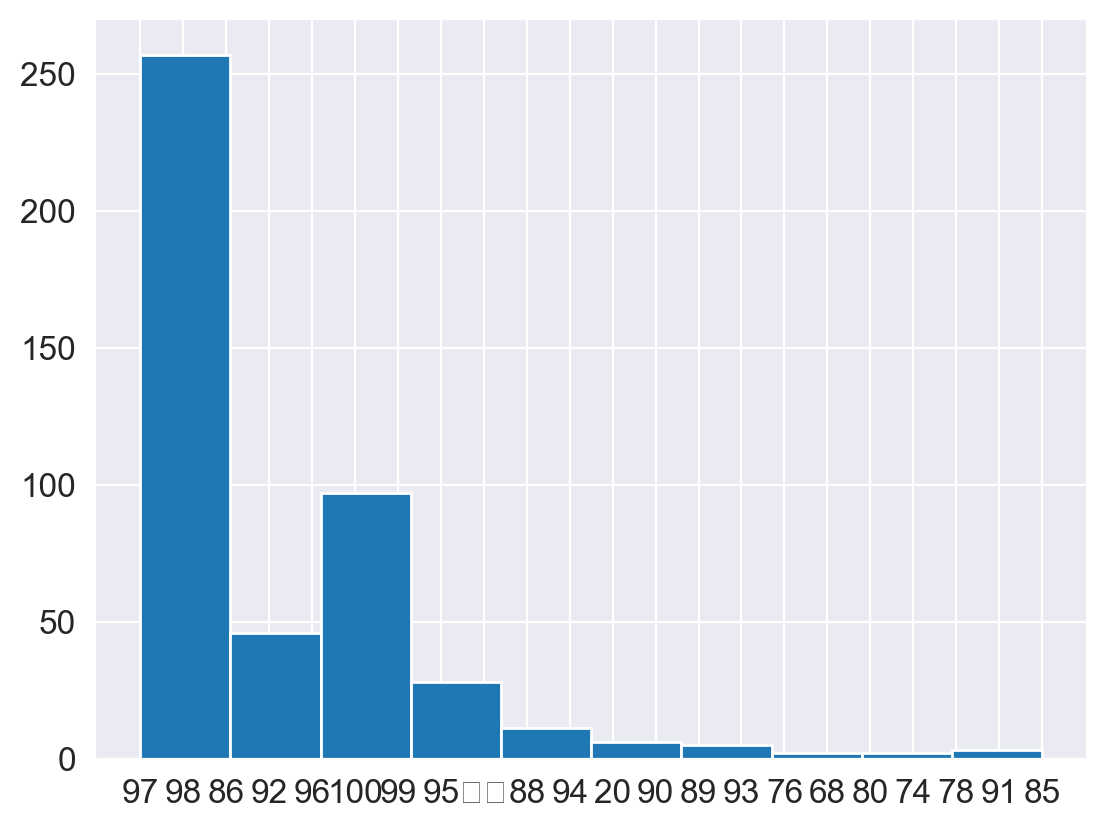

In [359]:
#Checking the distribution of the missing features
train_df['Saturation'].hist()

<Axes: >

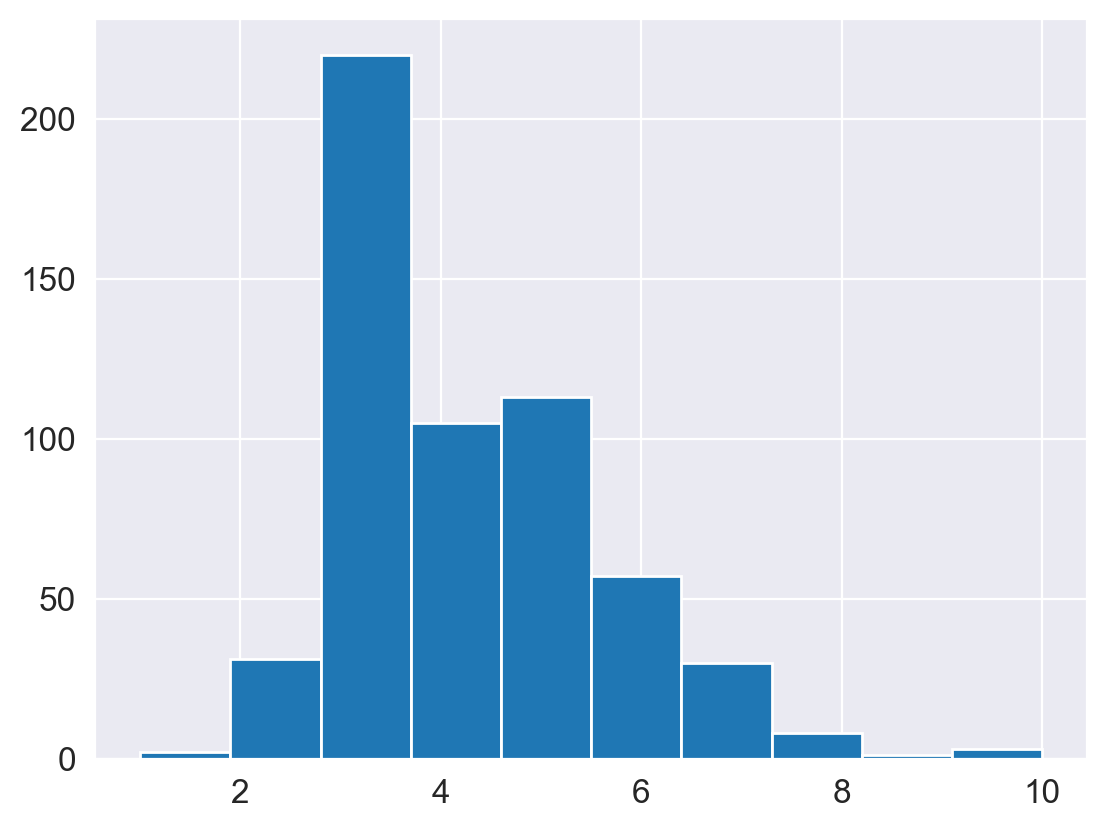

In [360]:
train_df['NRS_pain'].hist()

* Since the distribution of data for these features is skewed, we will impute using the median
* This strategy is justified as most of the values are centred around the median

## Feature Types

There are two types of variables:

1. **Numeric Variables** that can be exposed on a numeric scale. There are two basic categories of numeric variables:
* Continuous : can take any value within a range
* Discrete : can only take certain integer values
2. **Categorical Variables** that can take a fixed amount of values that correspond to a set of possible categories

Different visualisation techniques apply to each type so it's useful to isolate and analyze them.

In [361]:
numeric_atts = train_df.select_dtypes(exclude=['object'])
cat_atts = train_df.select_dtypes(include=['object'])

print("Number of Numeric Columns : {}".format(numeric_atts.shape[1]))
print("Number of Categorical Columns : {}".format(cat_atts.shape[1]))

Number of Numeric Columns : 16
Number of Categorical Columns : 8


In [362]:
cat_atts

Chief_complain  SBP  DBP   HR  RR    BT Saturation  \
767  sezure like motion  120   81   63  16  36.8        NaN   
35         hematochezia  120   80   84  20  36.8         97   
18             RUQ pain  100   60   90  20  36.4         98   
797           dizziness   94   54   85  18    35        NaN   
481         Foot Injury  112   72   56  20  36.9        NaN   
..                  ...  ...  ...  ...  ..   ...        ...   
853            vomiting  120   75   84  16  36.9        NaN   
119                  HA  152   96   50  16  36.7        NaN   
169   right hemiparesis  160  100   64  20  36.5         94   
350        pain on Knee  111   69  101  20  36.5        NaN   
932                 LOC  100   60   75  20  36.2         98   

                                Diagnosis in ED  
767                                  Meningioma  
35    Gastrointestinal haemorrhage, unspecified  
18                                Hepatitis NOS  
797                            Anxiety disorder  
481                          Cellulitis of foot  
..                                          ...  
853                       Acute gastroenteritis  
119                                    Headache  
169  Intracerebral haemorrhage in basal ganglia  
350                               Alcohol abuse  
932                                     Syncope  

[1013 rows x 8 columns]

* Except 'Chief_complain' and 'Diagnosis in ED', the other features are continuous numeric and have to be converted to numeric data types

In [363]:
train_df[['SBP','DBP','HR','RR','BT','Saturation']] = train_df[['SBP','DBP','HR','RR','BT','Saturation']].apply(pd.to_numeric, errors='coerce')
test_df[['SBP','DBP','HR','RR','BT','Saturation']] = test_df[['SBP','DBP','HR','RR','BT','Saturation']].apply(pd.to_numeric, errors='coerce')

In [364]:
# Now, getting the new count
numeric_atts = train_df.select_dtypes(exclude=['object'])
cat_atts = train_df.select_dtypes(include=['object'])

print("Number of Numeric Columns : {}".format(numeric_atts.shape[1]))
print("Number of Categorical Columns : {}".format(cat_atts.shape[1]))

Number of Numeric Columns : 22
Number of Categorical Columns : 2


## Exploratory Data Analysis (EDA)

Since we have quite a number of features, so instead of visualising each feature individually,We will now split it in batches of 10 and plot histograms for the numerical features, to check the distribution of data.

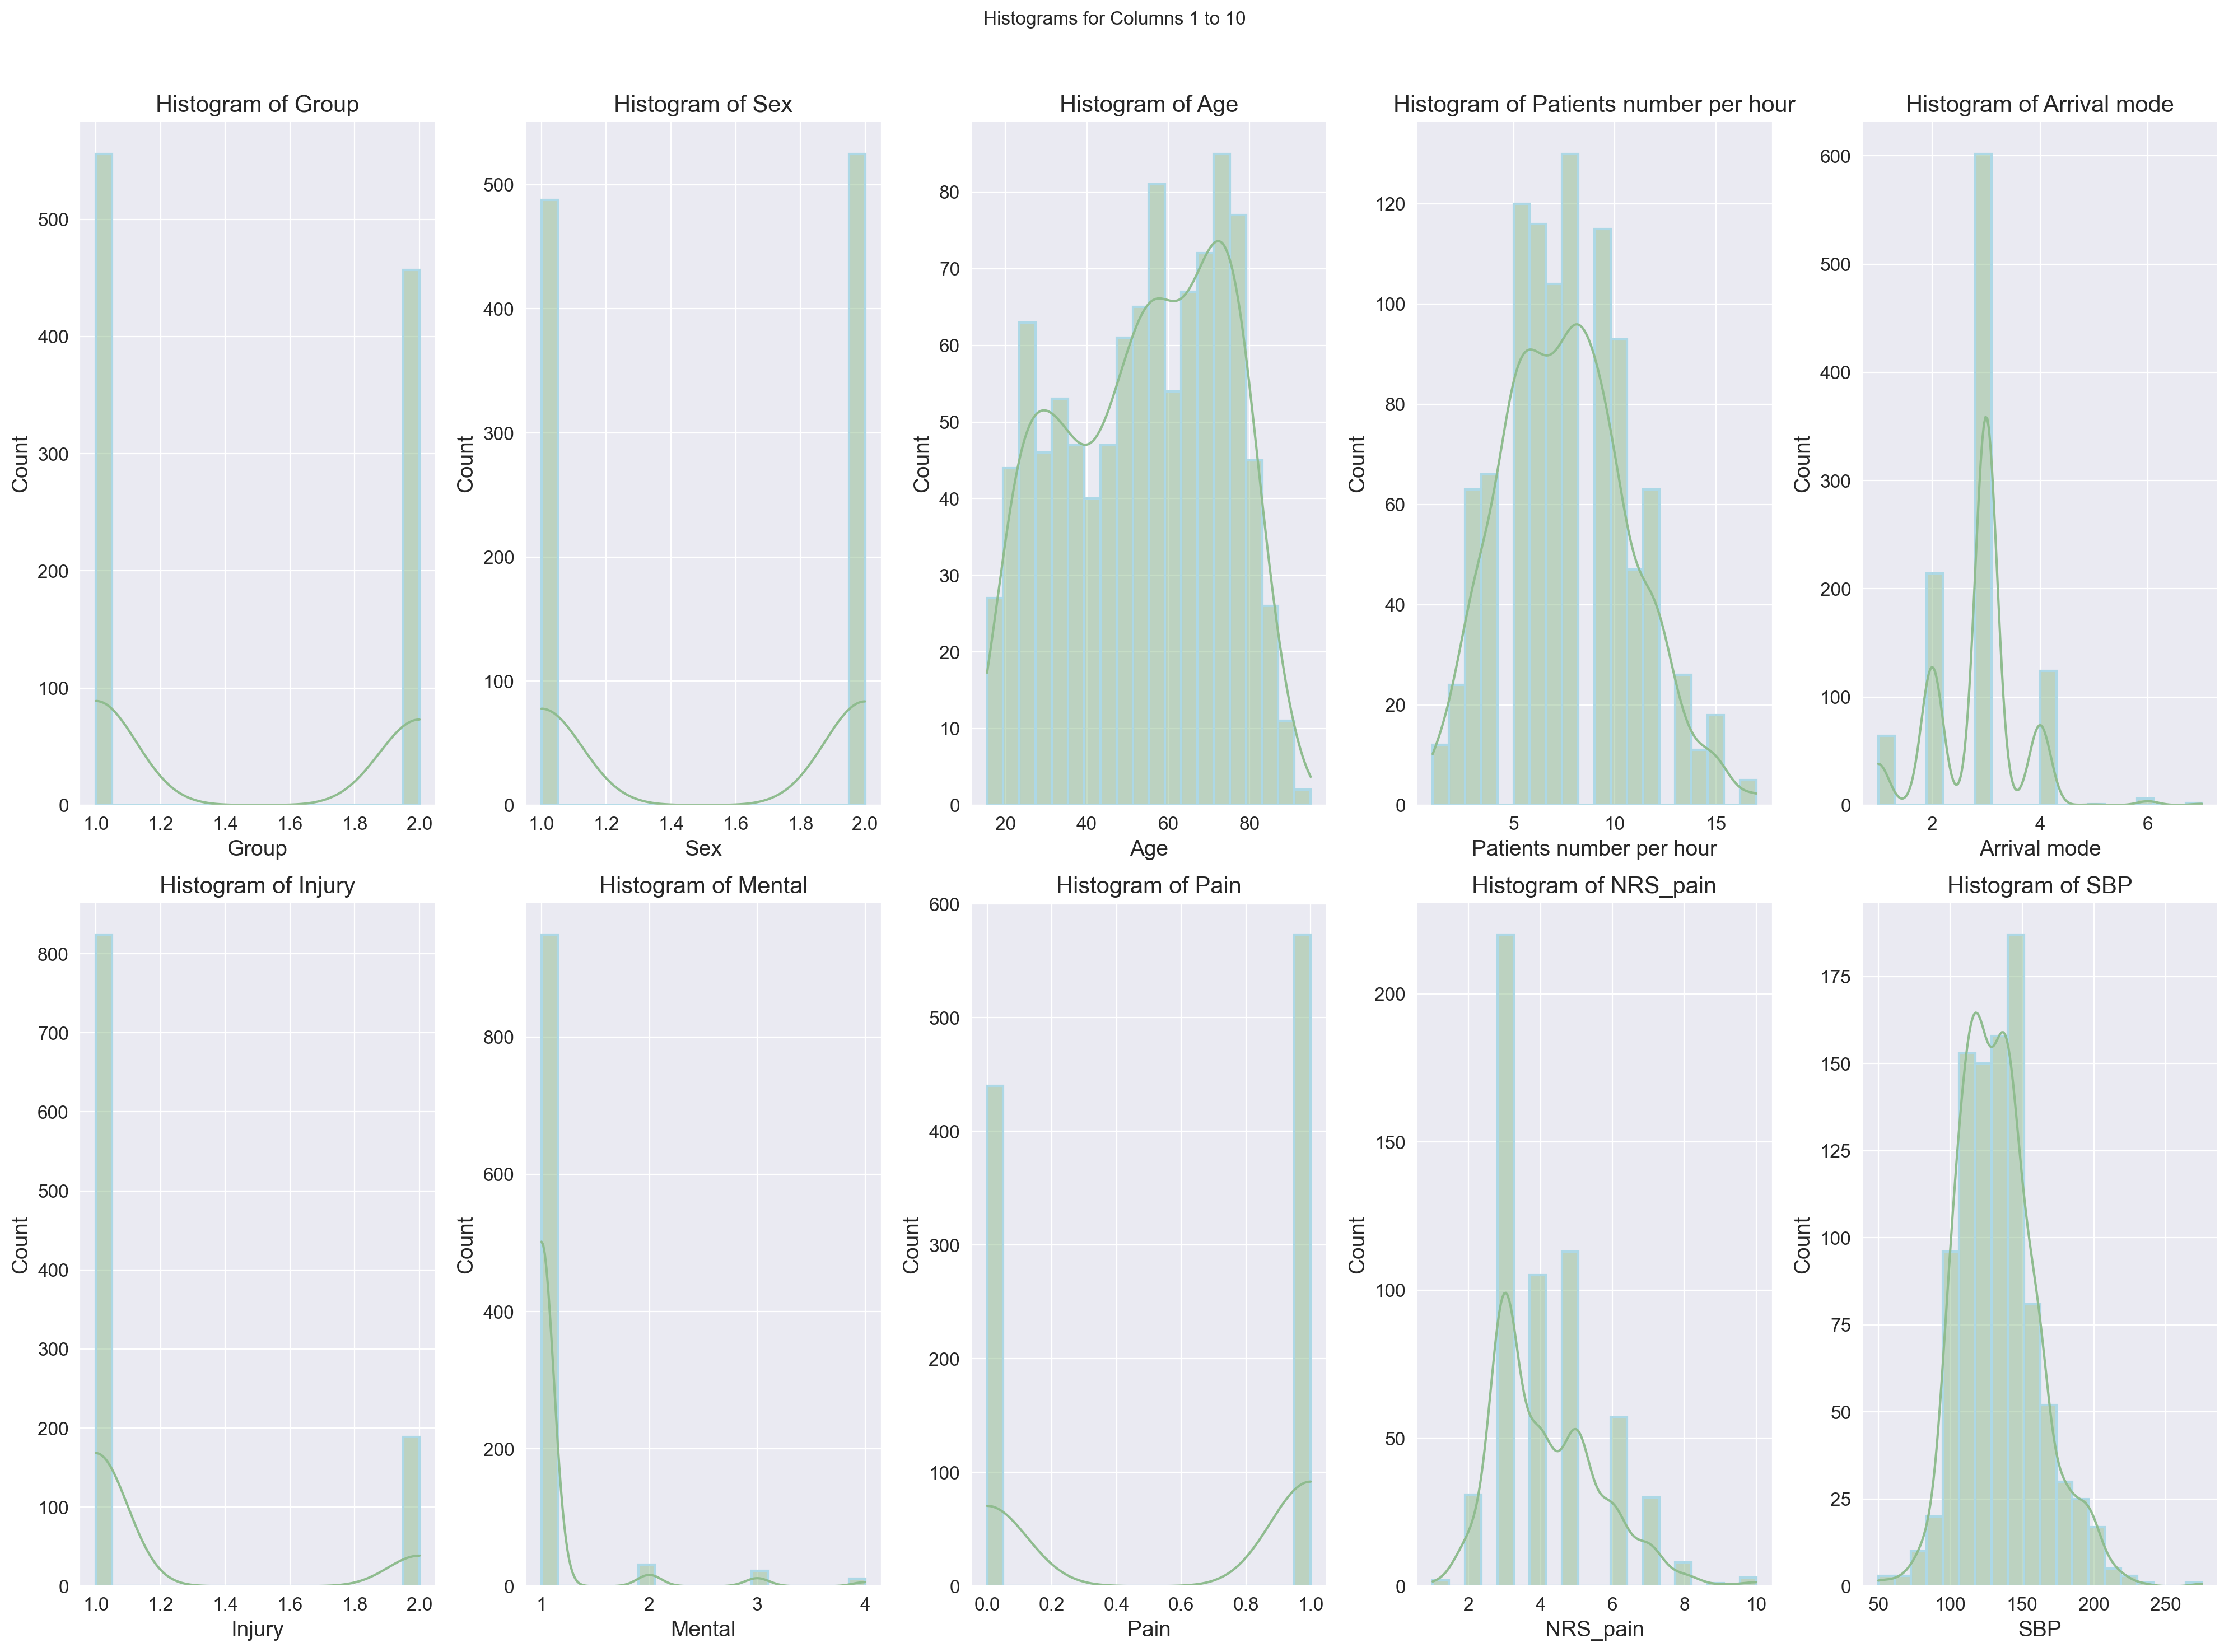

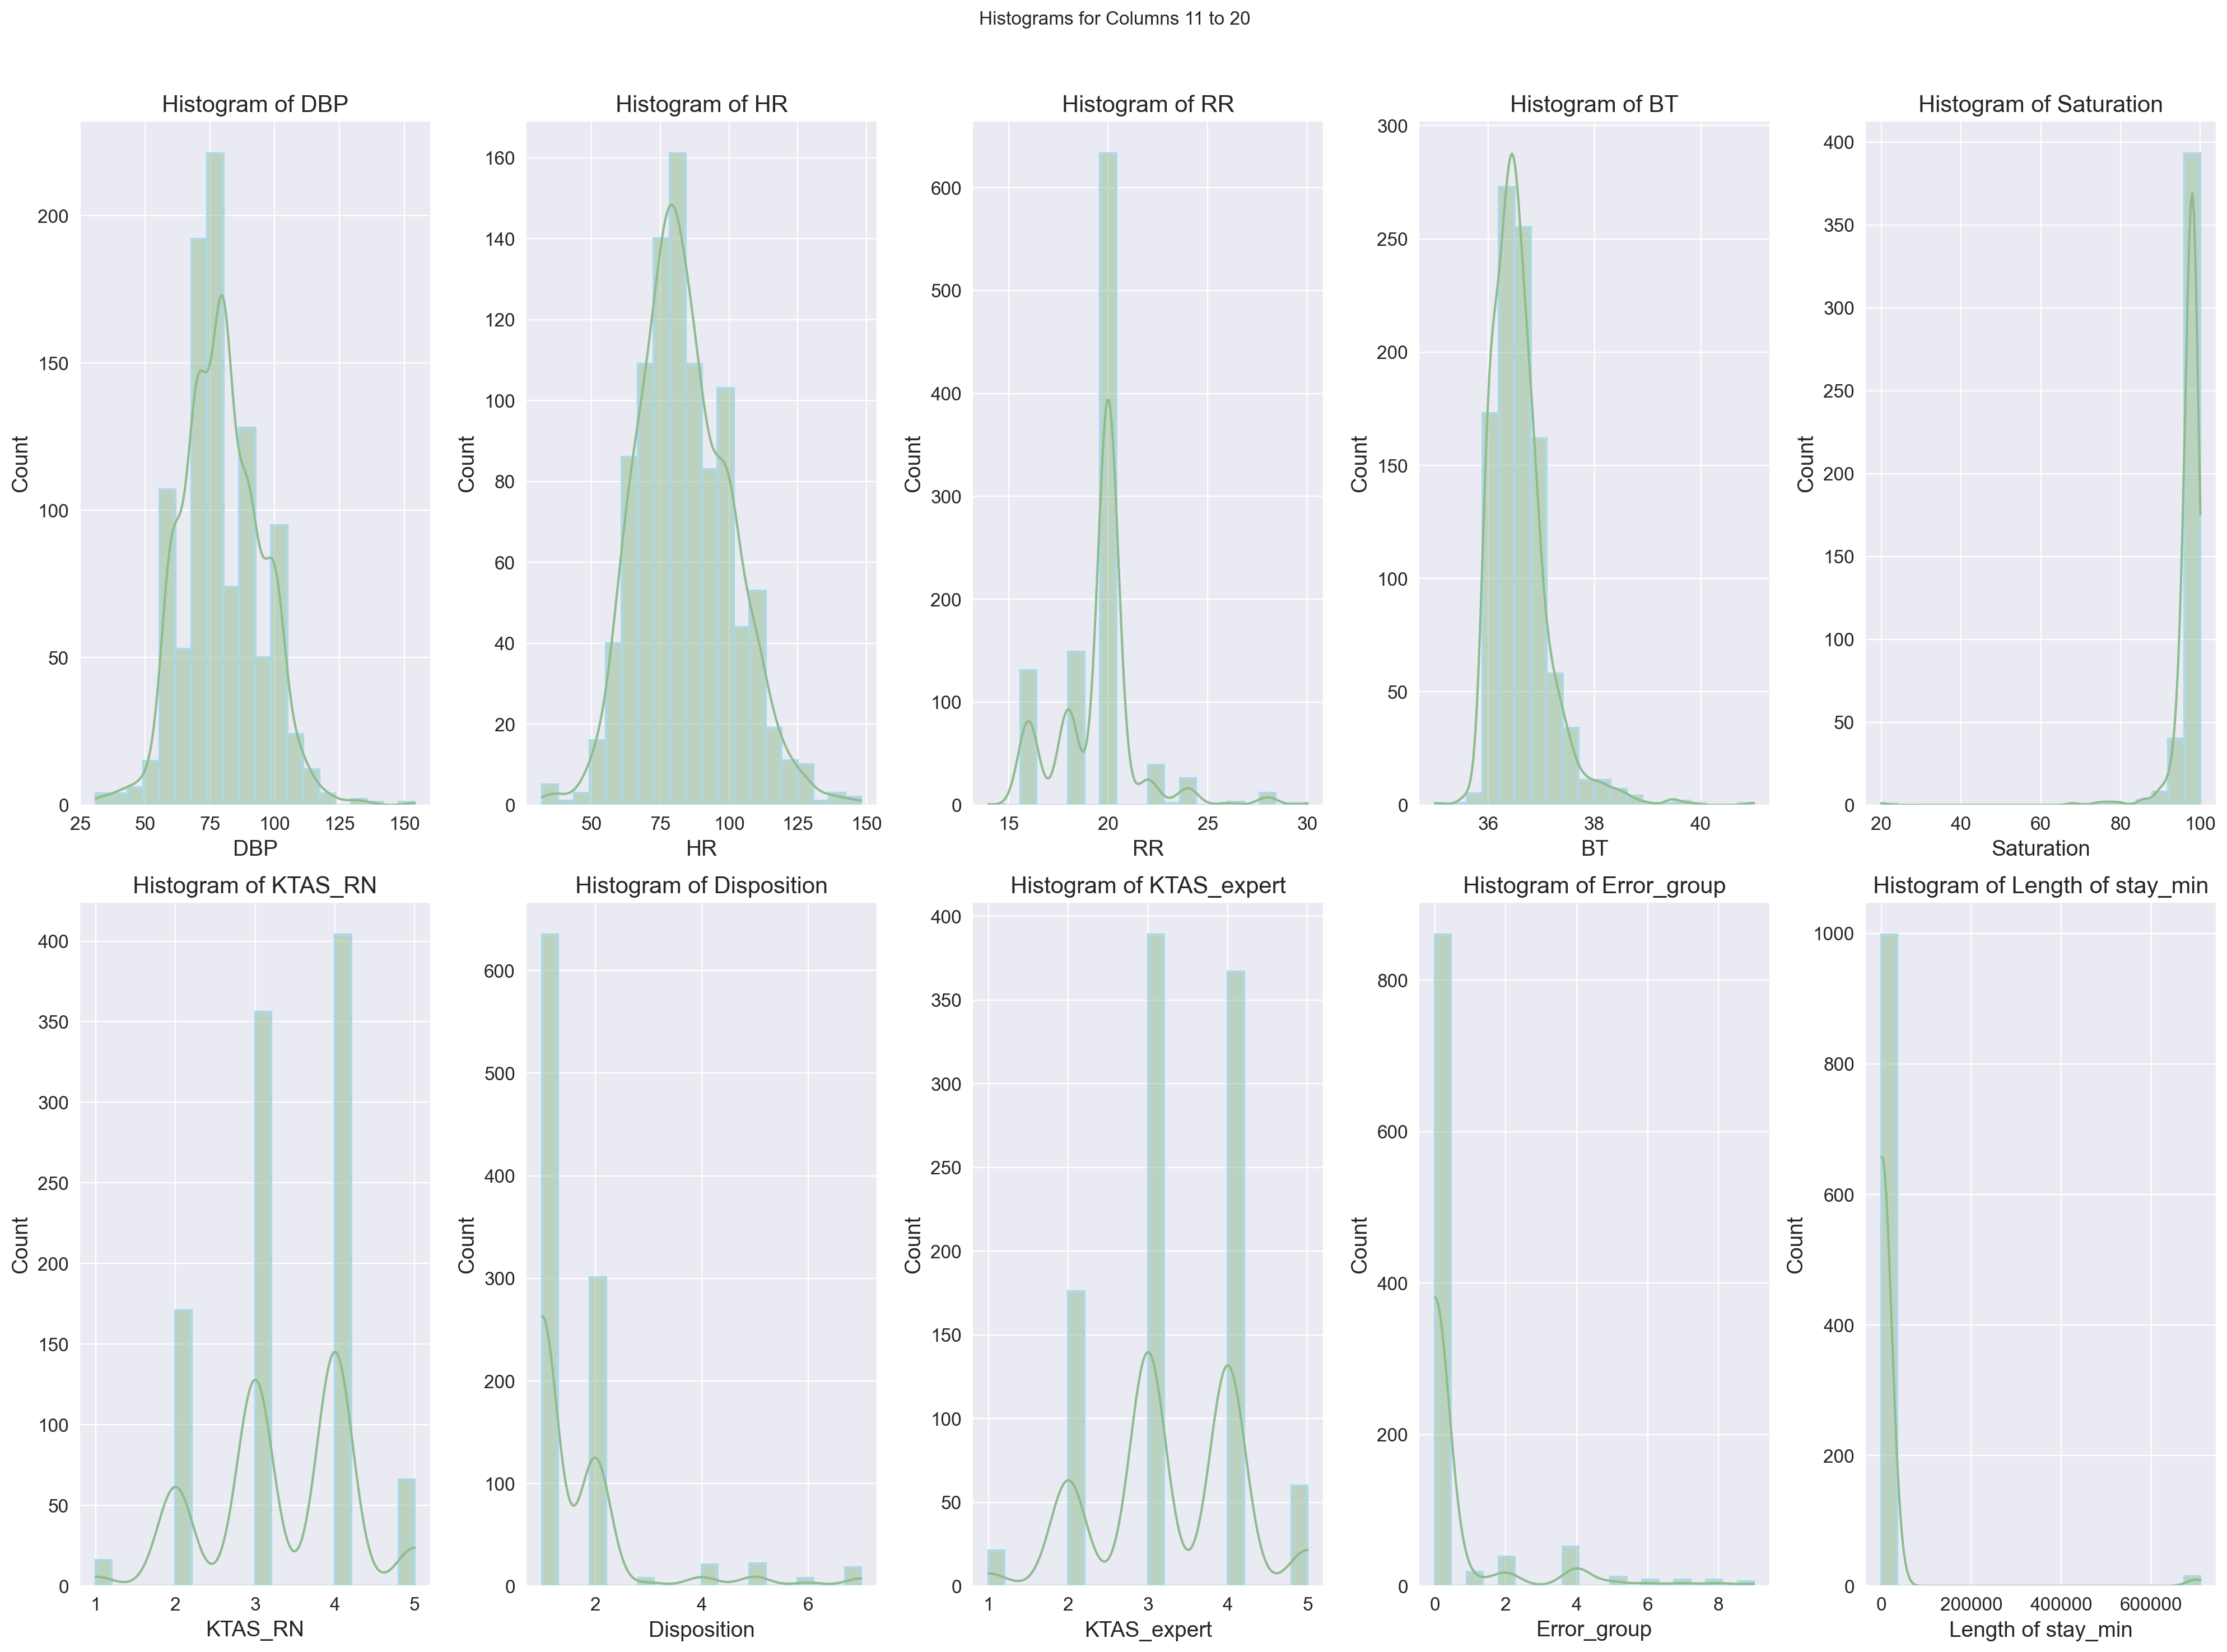

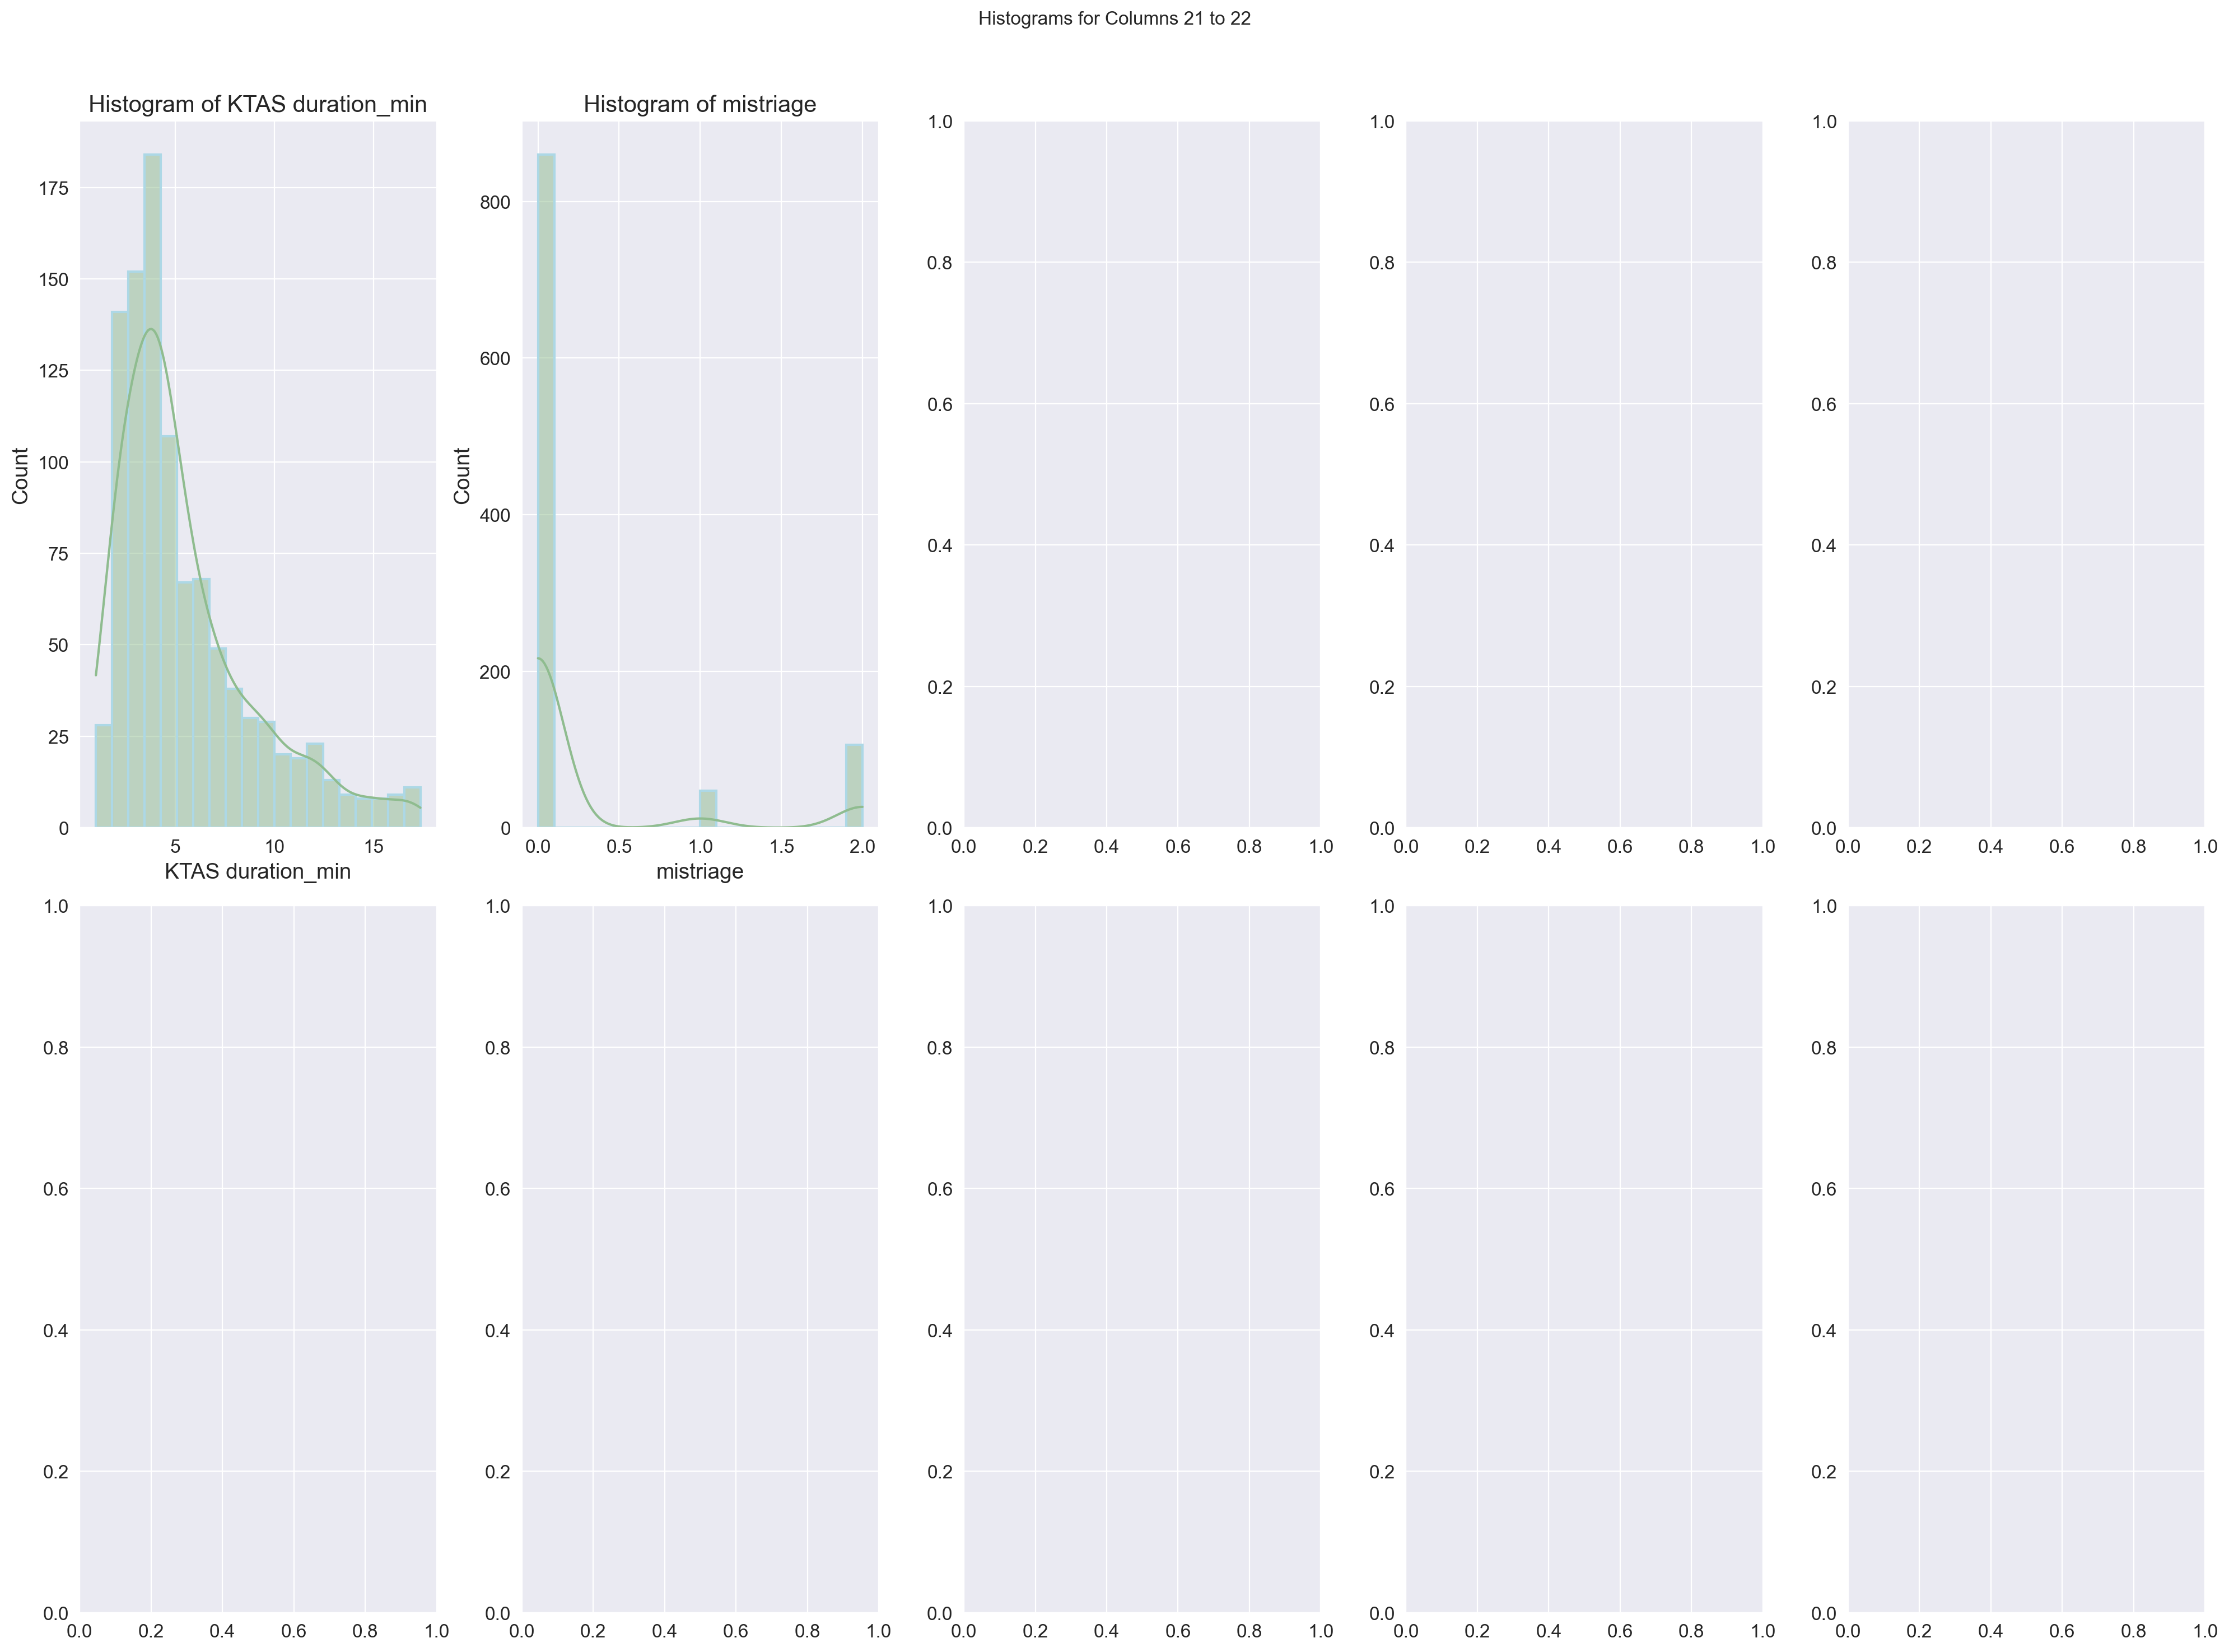

In [365]:
batch_size = 10 #Number of columns
total_columns = numeric_atts.shape[1]

for start in range(0,total_columns,batch_size):
    end = min(start+batch_size,total_columns)

    #Creating a figure for each batch
    fig, ax = plt.subplots(2,5, figsize=(20,15))
    ax = ax.flatten() #Flattening the axis to allow iteration

    #Plotting the histograms
    for index,column in enumerate(numeric_atts.columns[start:end]):
        sns.histplot(numeric_atts[column],bins=20,kde=True,ax=ax[index],
                     color='darkseagreen',edgecolor='lightblue',linewidth=1.5)
        ax[index].set_title(f'Histogram of {column}')

    plt.suptitle(f"Histograms for Columns {start+1} to {end}")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

* We can see that the discrete features like Group,Sex,Injury etc. take on only certain values
* Continuous features like KTAS duration_min,DBP,RR etc. are not normally distributed and are highly skewed, they will be seen to in the pre-processing stage
* We see that KTAS_expert, our target feature is highly imbalanced, which can highly affect the model bias

In [366]:
# Lets Check whether there are any features having low variance

#Defining a function to check for low variance
def low_variance(df,thd=0.9):

    columns = []
    for column in df.columns:

        values = df[column].value_counts(normalize=True) #To get the relative frequencies of values
        if (values > thd).sum() > 0: #Checking whether one value is greater than the threshold
            columns.append(column)
    return columns



In [367]:
#Checking which features have low variance

thd = 0.9 #Setting the threshold to 90%
columns_low_var = low_variance(numeric_atts,thd)

print('Numeric attributes with mostly the same value (>{}%):'.format(thd*100))
print(*columns_low_var, sep = ',\n')


Numeric attributes with mostly the same value (>90.0%):
Mental


Since, it will contribute little to nothing towards the predictive power of our model, we will drop it

In [368]:
train_df.drop(['Mental'],axis=1,inplace=True)
test_df.drop(['Mental'],axis=1,inplace=True)
numeric_atts.drop(['Mental'],axis=1,inplace=True)

Lets now plot a **boxplot** for each feature and check for outliers

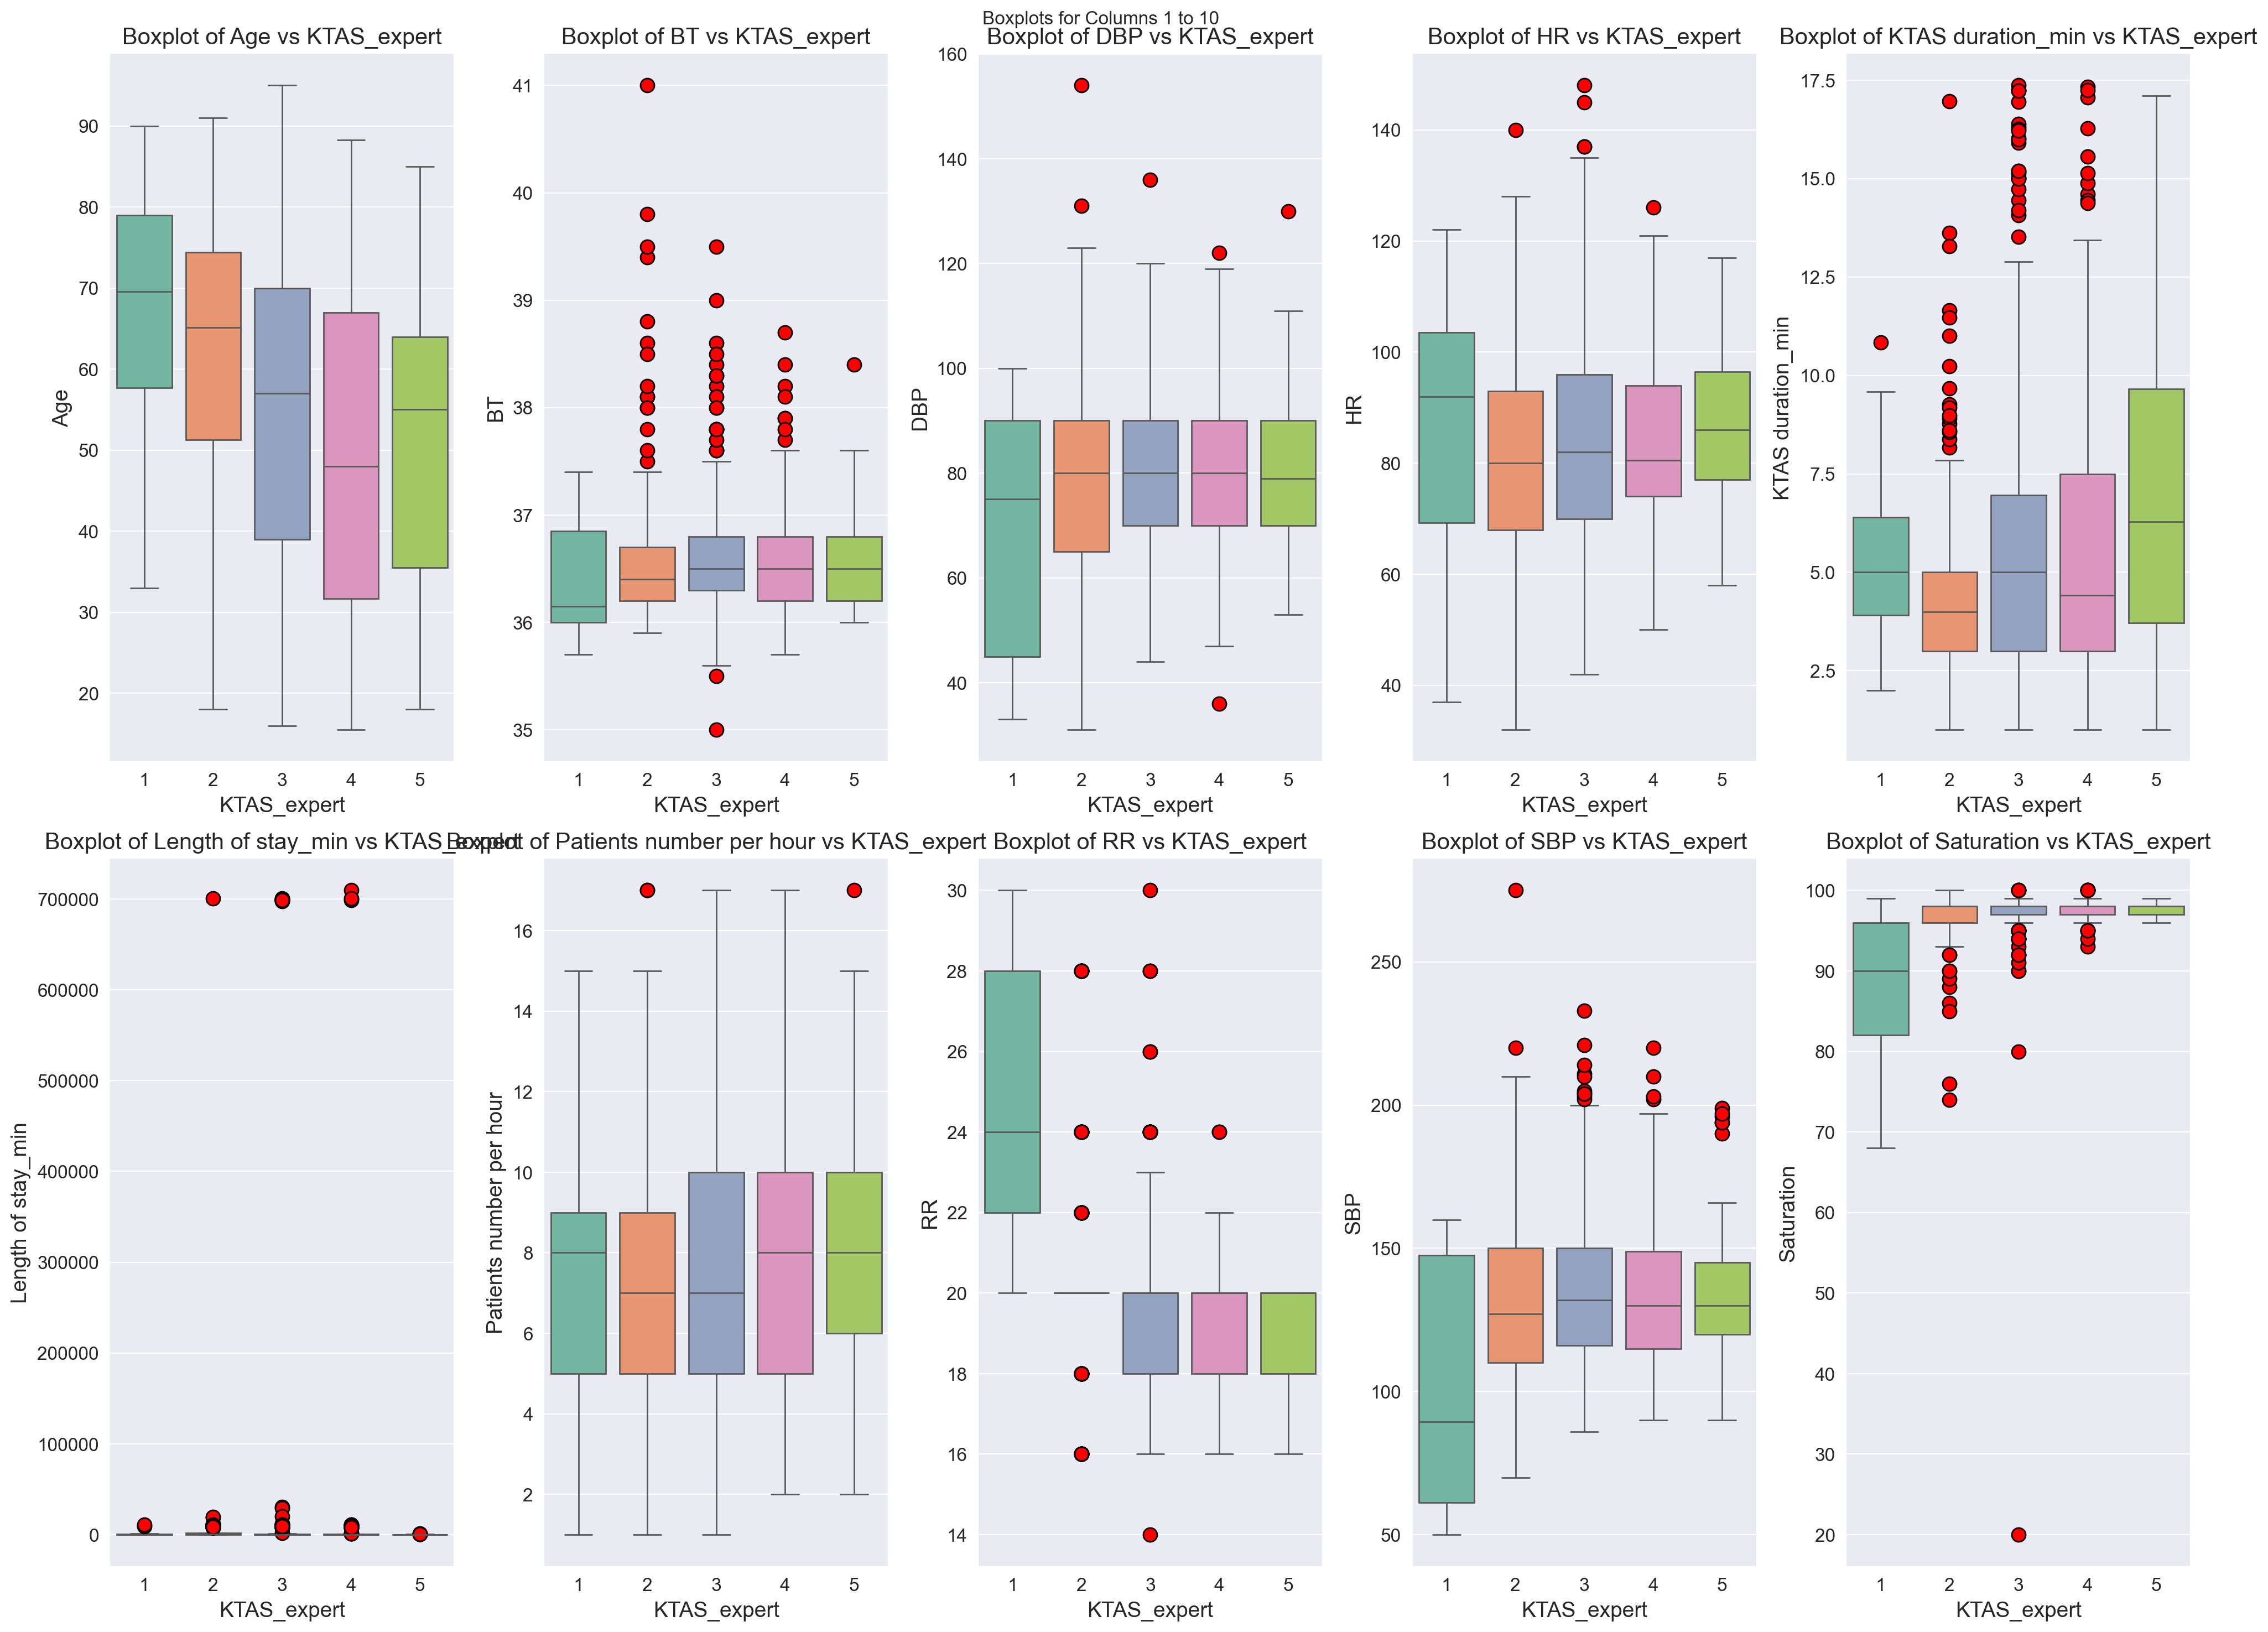

In [369]:
#Separating the discrete attributes from the continuous attributes
discrete_n_atts = ['Group','Sex','Arrival mode','Injury','Pain','NRS_pain','KTAS_RN','Disposition','KTAS_expert','Error_group','mistriage']
continuous_n_atts = np.setdiff1d(numeric_atts.columns, discrete_n_atts)

batch_size = 10
total_columns = len(continuous_n_atts)
dependent_feature = 'KTAS_expert'

#Setting the minute details
flierprops = dict(marker='o', markerfacecolor ='r', markeredgecolor='k', markersize = 9)

for start in range(0, total_columns, batch_size):
    end = min(start+batch_size, total_columns)

    fig, ax = plt.subplots(2,5,figsize = (20,15))
    ax=ax.flatten()
    
    #Plotting the boxplots
    for index,column in enumerate(continuous_n_atts[start:end]):
        sns.boxplot(x=dependent_feature, y=column, data=numeric_atts, ax=ax[index], palette='Set2',flierprops=flierprops)
        ax[index].set_title(f"Boxplot of {column} vs {dependent_feature}")
    plt.suptitle(f"Boxplots for Columns {start+1} to {end}")
    plt.tight_layout()
    plt.show()

* The distributions vary with some features having higher variance compared to the others
* As we can see, there are a large number of outliers for all features except Age, which will be addressed later

## Target Variable : KTAS_expert

Let's have a look at the target variable in greater detail

In [370]:
#Getting the count of each value
train_df['KTAS_expert'].value_counts()

KTAS_expert
3    389
4    367
2    176
5     60
1     21
Name: count, dtype: int64

* As said earlier, there is class imbalance present in this dataset, which will be addressed in the pre-processing stage
* Since there are 5 levels of triage, this is a case of multi-class classification

Text(0, 0.5, 'Count')

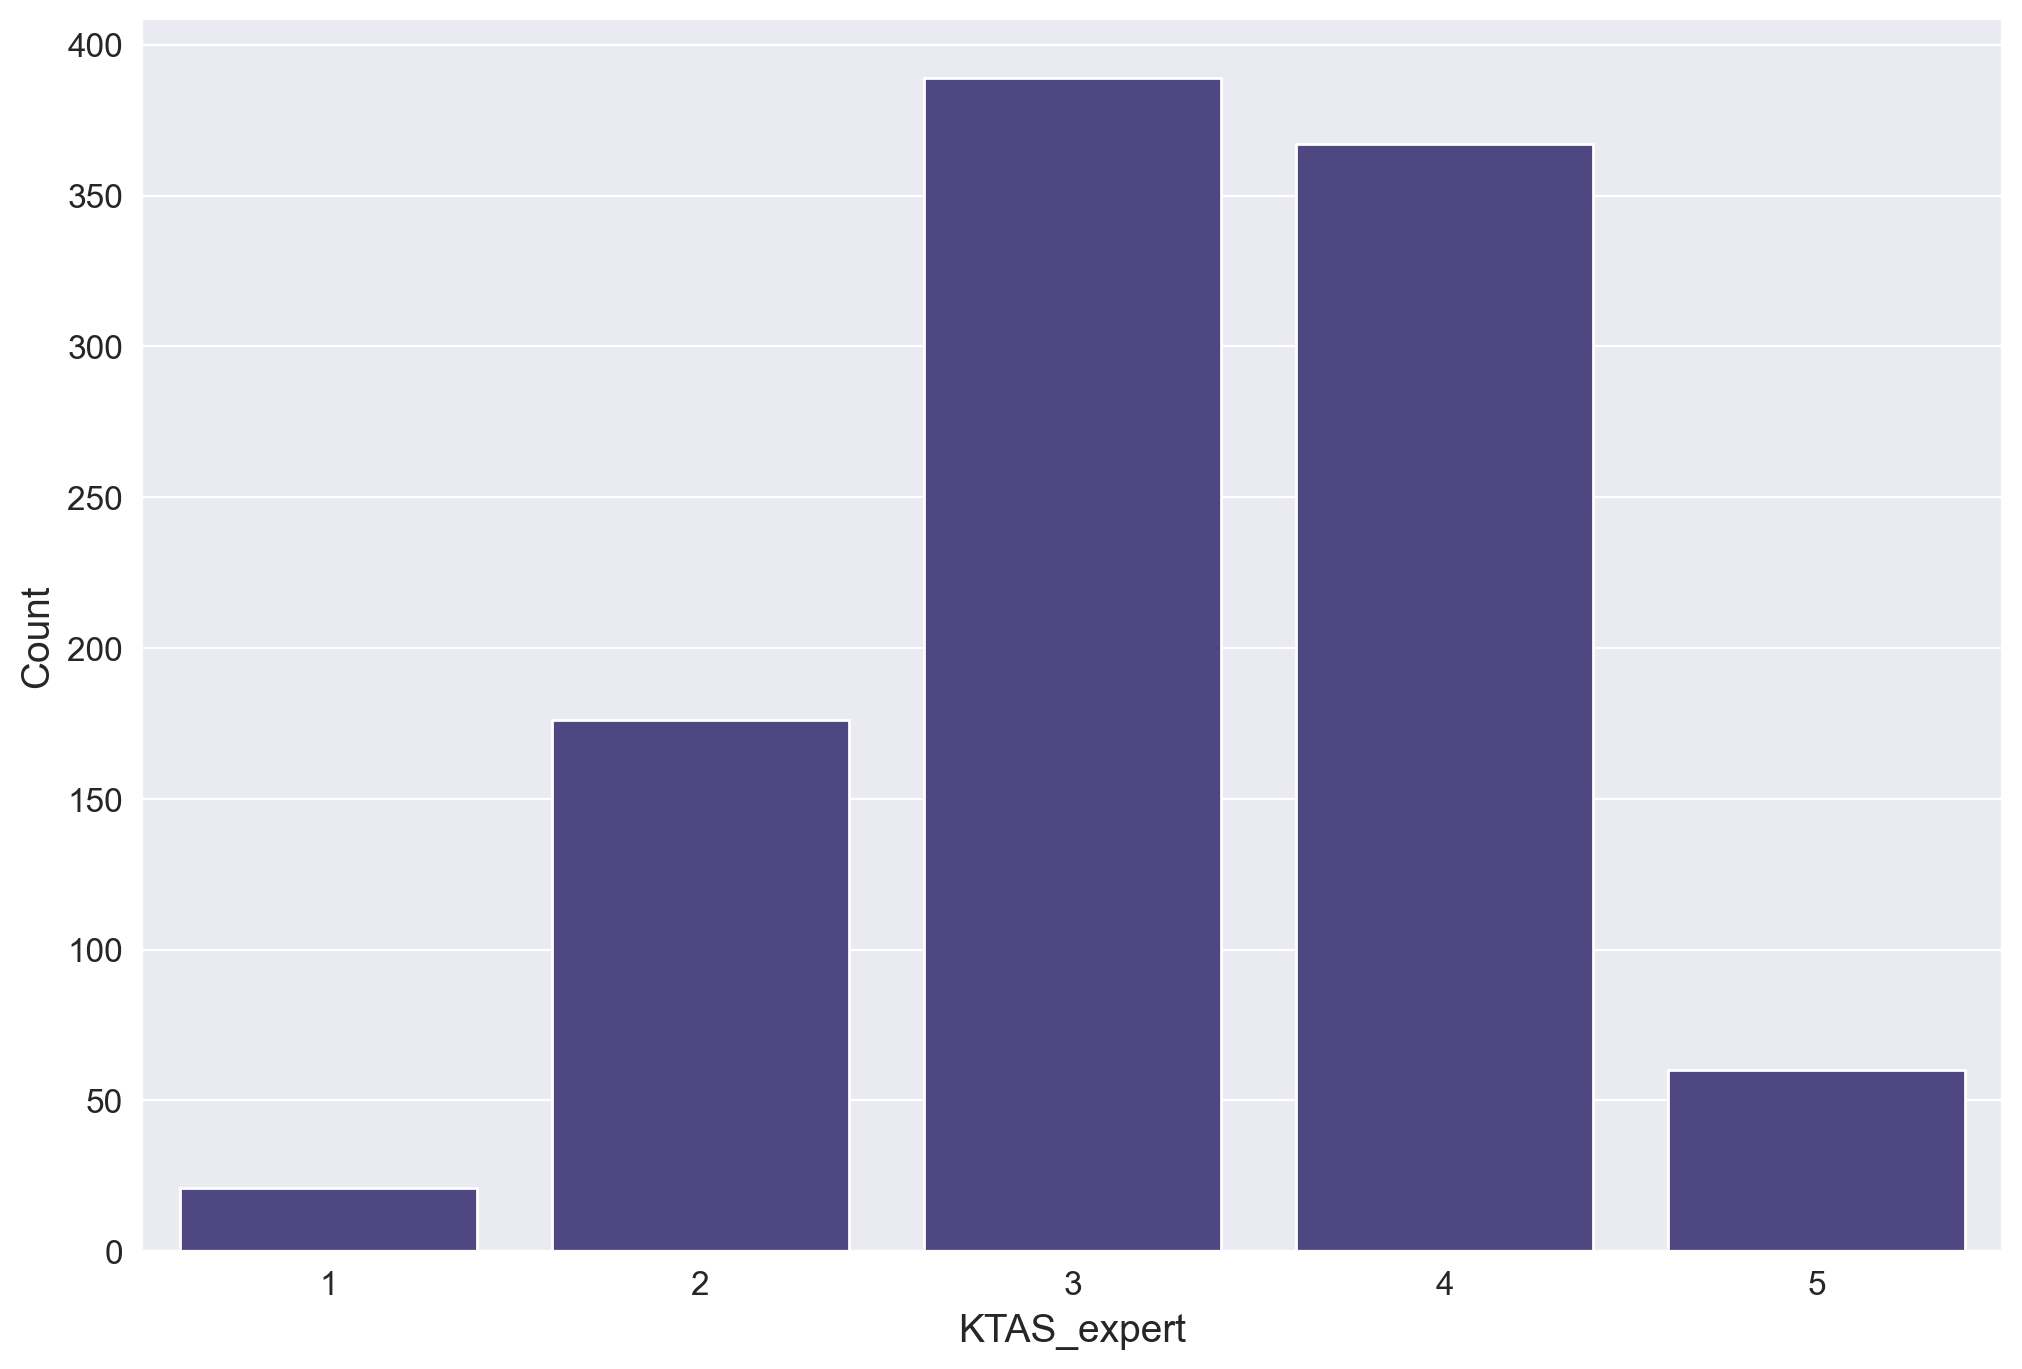

In [371]:
#Converting the feature from numerical to categorical to visualise it
train_df['KTAS_expert'] = train_df['KTAS_expert'].astype('category')

fig, ax = plt.subplots(1,1,figsize = (12,8))
sns.countplot(x=train_df['KTAS_expert'],color='darkslateblue')
plt.xlabel('KTAS_expert')
plt.ylabel('Count')

## Bivariate Analysis

We will now perform the Kruskal-Wallis test to see if there is a significant difference in the mean of the independent features for all the classes

In [372]:
from scipy.stats import kruskal

t_test_res = {}     # To store p-values
sig_feat = []       # To record all the significant features

# Getting the unique class labels
class_labels = numeric_atts['KTAS_expert'].unique()

# Looping through all numeric features except 'KTAS_expert'
for column in numeric_atts.columns:
    if column == 'KTAS_expert':
        continue

    # Gather data for each class
    groups = [
        numeric_atts.loc[numeric_atts['KTAS_expert'] == label, column].dropna()
        for label in class_labels
    ]

    # Performing Kruskal-Wallis test
    stat, p_value = kruskal(*groups)
    t_test_res[column] = p_value

    if p_value < 0.05:
        sig_feat.append(column)
        print(f"{column} : p-value = {p_value:.4f}")

# Final list of significant features
print("\n Significant features (p < 0.05):")
print(sig_feat)


Group : p-value = 0.0000
Sex : p-value = 0.0014
Age : p-value = 0.0000
Injury : p-value = 0.0000
Pain : p-value = 0.0000
NRS_pain : p-value = 0.0000
SBP : p-value = 0.0289
RR : p-value = 0.0000
BT : p-value = 0.0390
Saturation : p-value = 0.0039
KTAS_RN : p-value = 0.0000
Disposition : p-value = 0.0000
Error_group : p-value = 0.0001
Length of stay_min : p-value = 0.0000
KTAS duration_min : p-value = 0.0000
mistriage : p-value = 0.0000

 Significant features (p < 0.05):
['Group', 'Sex', 'Age', 'Injury', 'Pain', 'NRS_pain', 'SBP', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Disposition', 'Error_group', 'Length of stay_min', 'KTAS duration_min', 'mistriage']


* These are the features which affect the target variable the most
* We will select these features during the data pre-processing and modelling stage
* Before finalising these features, let us check for multi-collinearity

In [373]:
# Dropping some features not required for real-time prediction
sig_feat = ['Group', 'Sex', 'Age', 'Injury', 'Pain', 'NRS_pain', 'SBP', 'RR', 'BT', 'Saturation', 'KTAS_RN']

<Axes: >

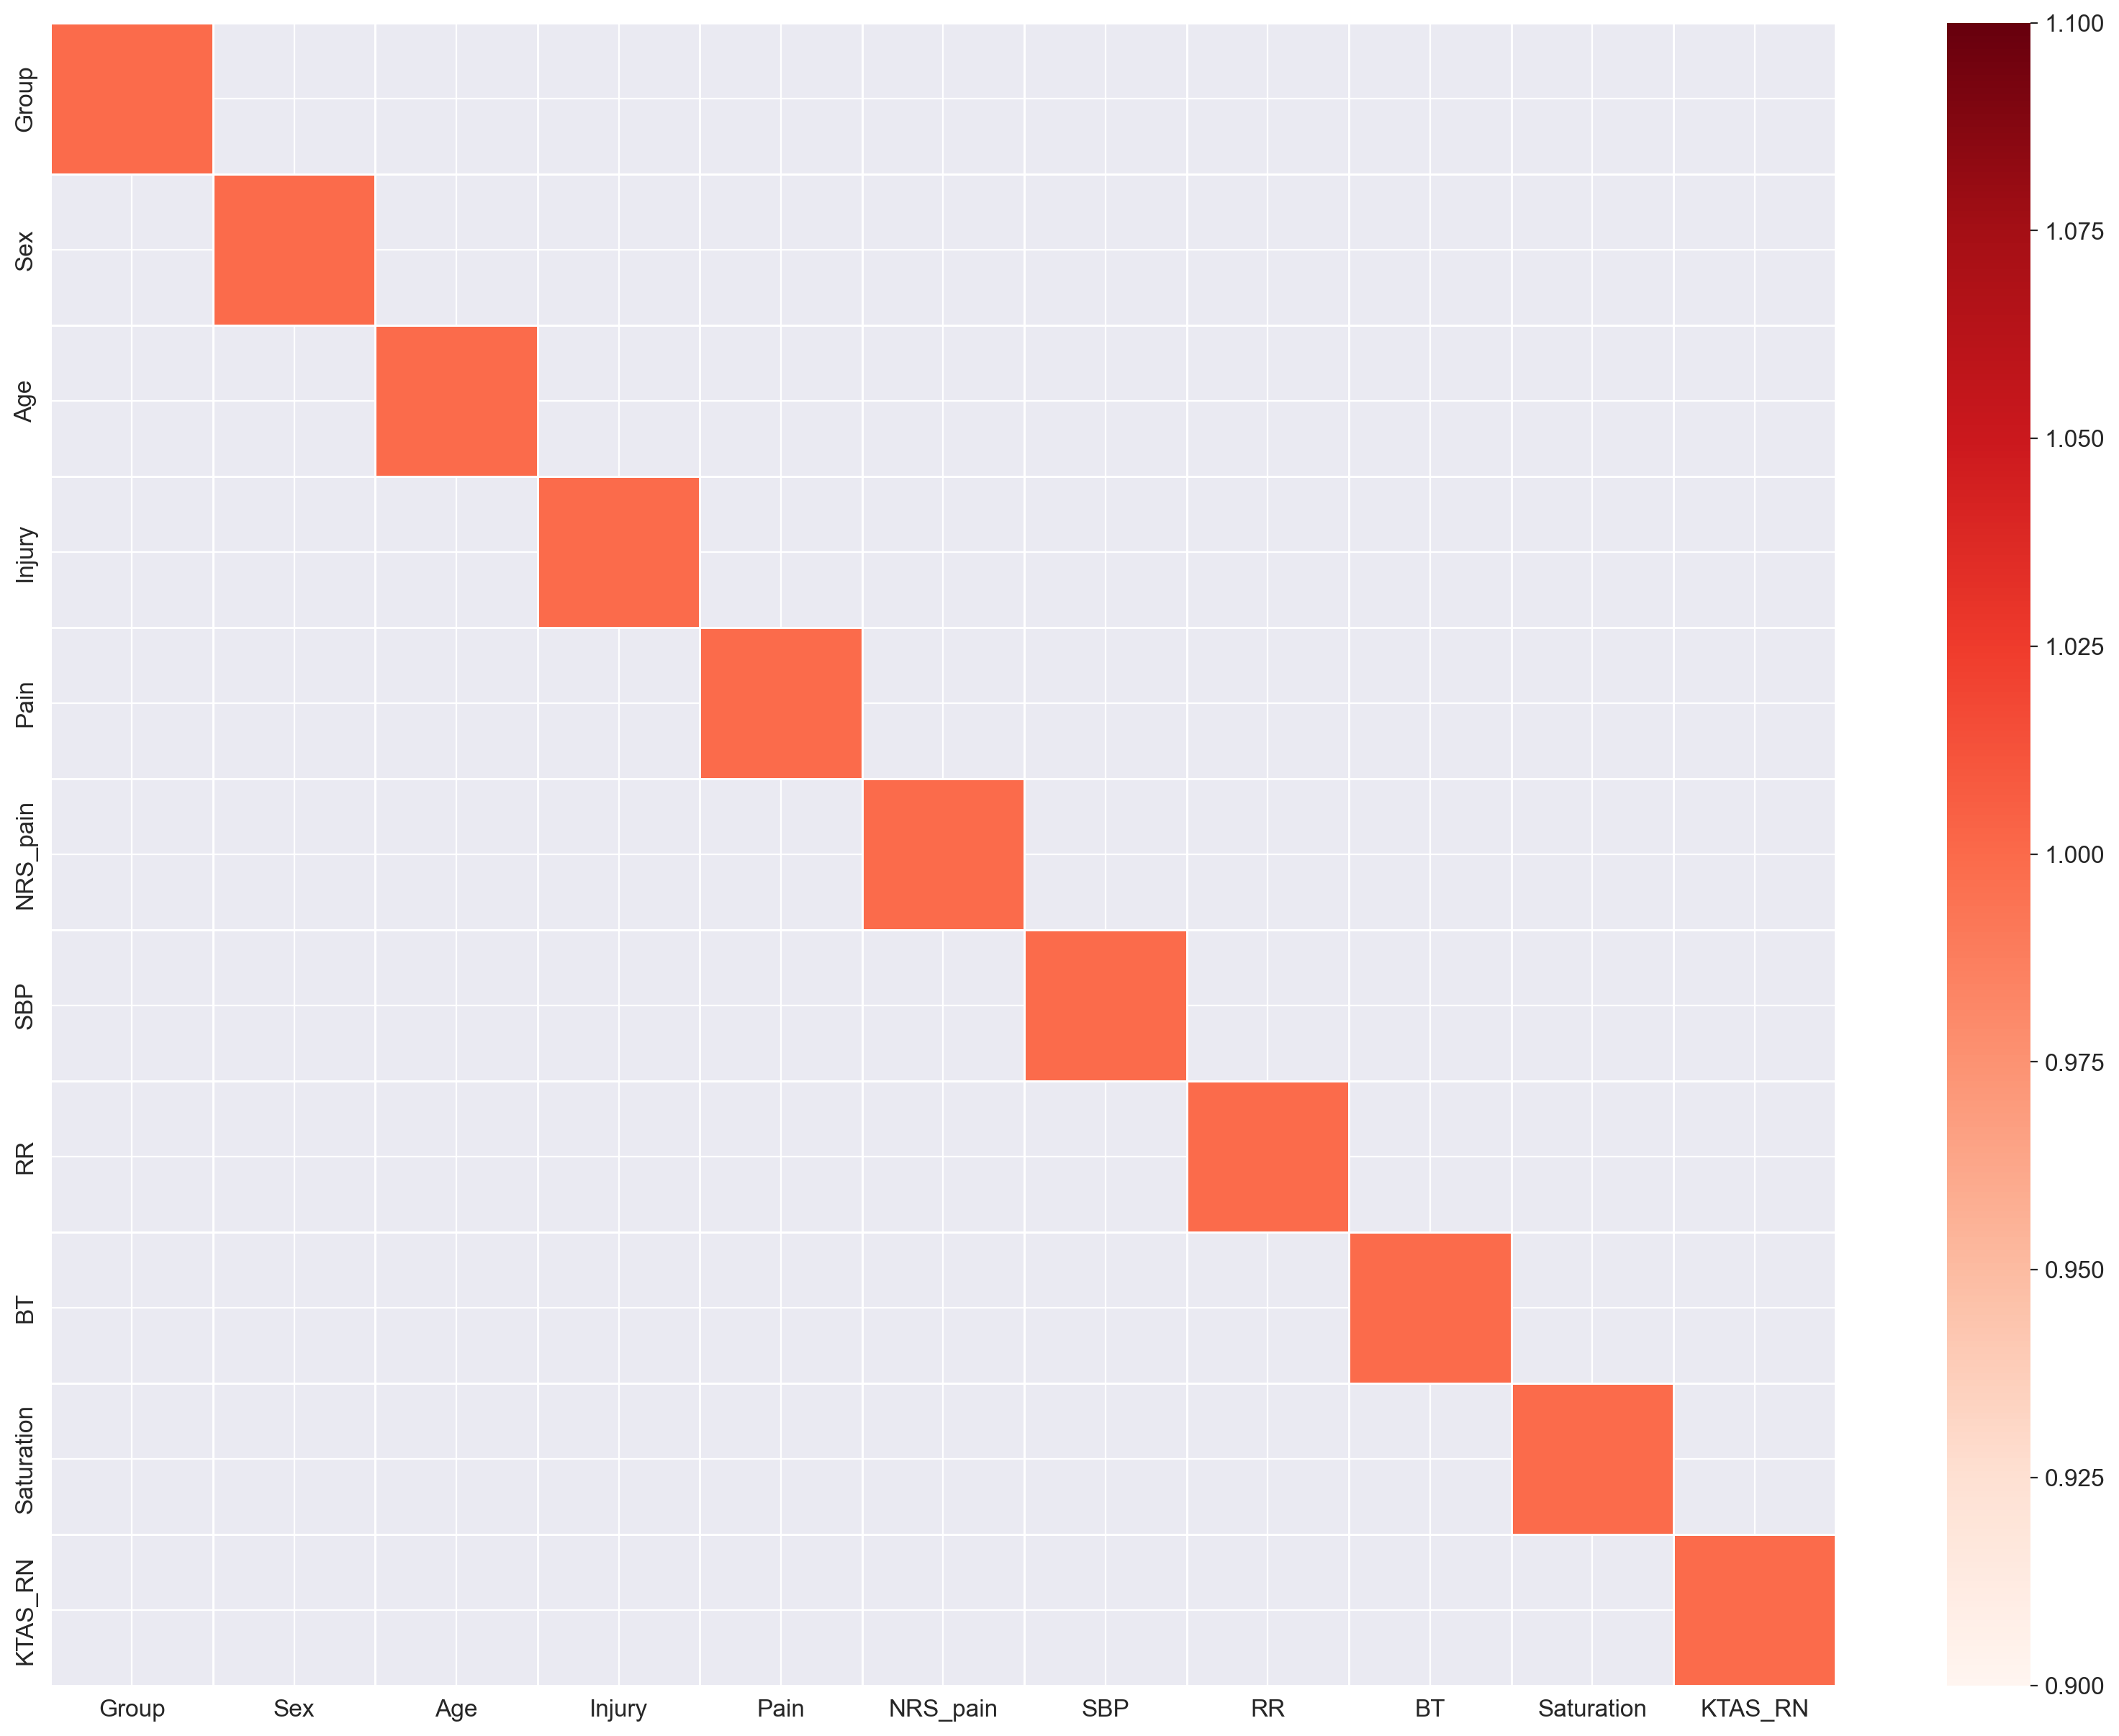

In [374]:
#Checking for correlations and masking for values greater than 50%
plt.figure(figsize=(20,15))

corr_matrix = numeric_atts[sig_feat].corr()
sns.heatmap(corr_matrix, mask=corr_matrix < 0.5, linewidth=1, cmap='Reds')

Since, there is no correlation between the features, we can rule out the case of **multi-collinearity**

# Data Preprocessing

Now, that we have completed our EDA, we will go on to perform operations on our data to make it ready to be fed into the Machine Learning Models

### Textual Preprocessing

First, of all we will separate the feature 'Cheif_complain' and in a separate dataframe and **perform Natural Language Processing (NLP)**  operations on it

In [375]:
train_nlp = train_df[['Chief_complain']].reset_index(drop=True)
test_nlp = test_df[['Chief_complain']].reset_index(drop=True)

In [376]:
# Viewing the textual data
train_nlp.head()

Chief_complain
0  sezure like motion
1        hematochezia
2            RUQ pain
3           dizziness
4         Foot Injury

## Plotting Wordclouds for the textual features

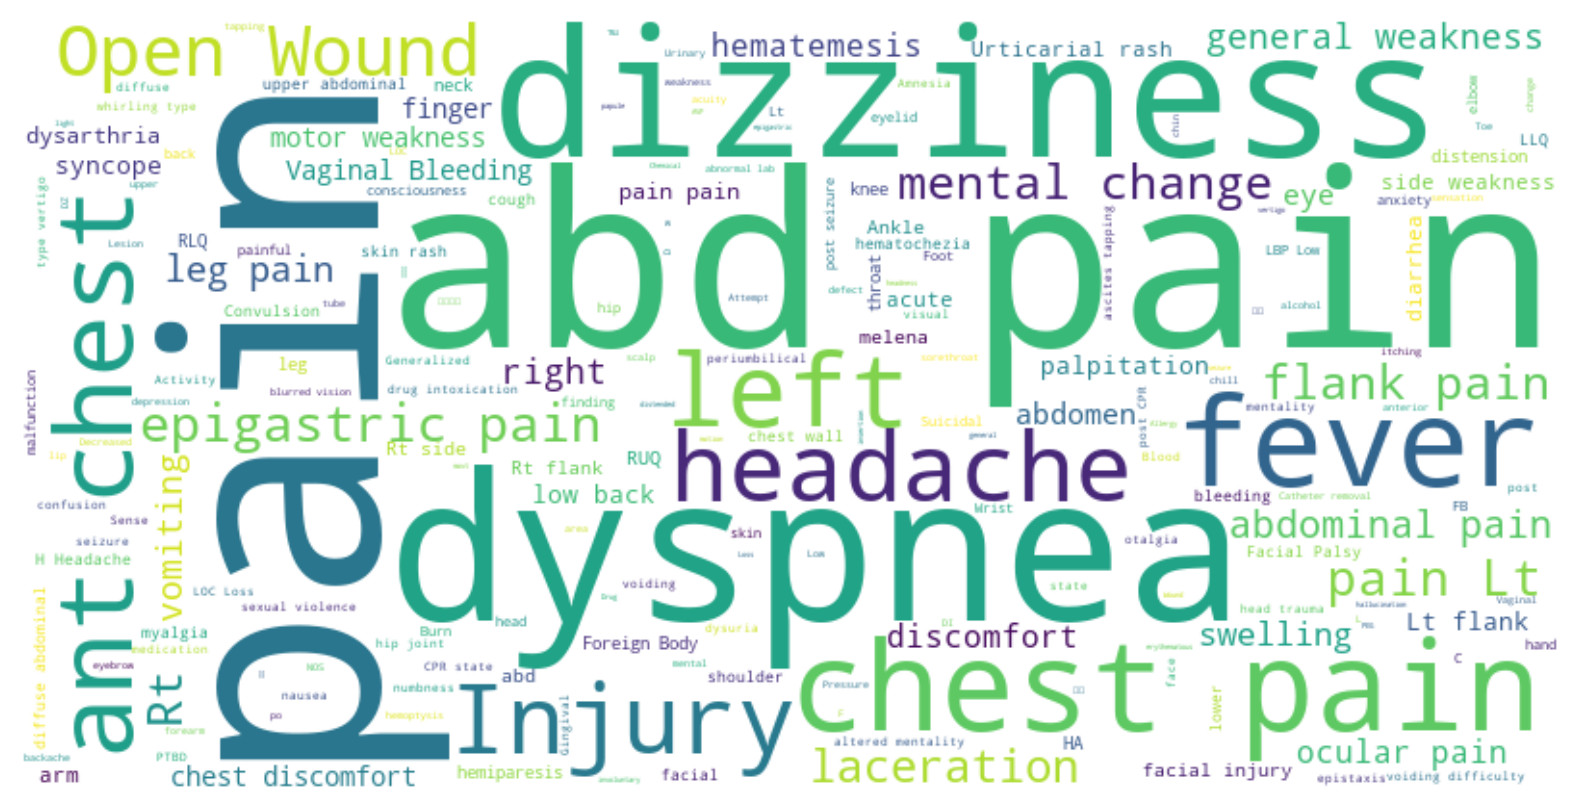

In [377]:
from wordcloud import WordCloud

# Combining all the text into one big string
text = " ".join(train_nlp['Chief_complain'].astype(str).tolist())

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



### Cleaning the Textual Data

In [378]:
import re #regular expressions

# Common ED abbreviations
abbr_dict = {
    "f/c": "fever chills",
    "ruq": "right upper quadrant",
    "n/v": "nausea vomiting",
    "cp": "chest pain",
    "nos": "not otherwise specified",
    "loc": "loss of consciousness",
    "lbp": "lower back pain",
    "ant": "anterior",
    "avf": "arteriovenous fistula",
    "peg": "percutaneous endoscopic gastrostomy",
    "abd": "abdomen",
    "cpr": "cardiopulmonary resuscitation",
    "llq": "left lower quadrant",
    "fb": "foreign body",
    "ptbd": "percutaneous transhepatic biliary drainage",
    "a/": "associated with",
    "rlq": "right lower quadrant",
    "hb": "hemoglobin",
    "dz": "dizziness",
    "sx": "symptoms",
    "bsl": "blood sugar level",
    "pprom": "preterm premature rupture of membranes",
    "ptx": "pneumothorax",
    "c/s": "cesarean section",
    "g/w": "general weakness"
}

# Defining a function to expand abbreviations
def expand_abbreviations(text):
    text = str(text).lower() #lowercase
    for abbr, full_form in abbr_dict.items():
        text = text.replace(abbr, full_form)
    return text

# Defining a function to clean the text
def clean_text(text):
    text = expand_abbreviations(text)
    text = re.sub(r'[^a-z\s,-]', '', text)  # keeping commas,spaces and hifens, removing other special characters
    text = re.sub(r'\s+',' ',text).strip() #removing extra spaces
    return text

#Applying to both columns on the train and test set
train_nlp['Chief_clean'] = train_nlp['Chief_complain'].apply(clean_text)
#train_nlp['diagnosis_clean'] = train_nlp['Diagnosis in ED'].apply(clean_text)
test_nlp['Chief_clean'] = test_nlp['Chief_complain'].apply(clean_text)
#test_nlp['diagnosis_clean'] = test_nlp['Diagnosis in ED'].apply(clean_text)

# Viewing the cleaned text
train_nlp[['Chief_clean']].head()





Chief_clean
0              sezure like motion
1                    hematochezia
2  right upper quadranterior pain
3                       dizziness
4                     foot injury

### Preprocessing the Text

In [379]:
# Removing the stopwords and lemmatizing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#Defining a function to preprocess the text
def preprocess(text):
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

#Applying the function
train_nlp['chief_final'] = train_nlp['Chief_clean'].apply(preprocess)
#train_nlp['diagnosis_final'] = train_nlp['diagnosis_clean'].apply(preprocess)

test_nlp['chief_final'] = test_nlp['Chief_clean'].apply(preprocess)
#test_nlp['diagnosis_final'] = test_nlp['diagnosis_clean'].apply(preprocess)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NATHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NATHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [380]:
# Converting the preprocessed textual data into features
from sklearn.feature_extraction.text import TfidfVectorizer
# Saving the model and the preprocessors
import pickle

#TF-IDF for chief_final
tfidf_chief = TfidfVectorizer(max_features=100,ngram_range=(1,2))
Xtrain_chief = tfidf_chief.fit_transform(train_nlp['chief_final'])
Xtest_chief = tfidf_chief.transform(test_nlp['chief_final'])

# TF-IDF for diagnosis_final
#tfidf_diag = TfidfVectorizer(max_features=100,ngram_range=(1,2))
#Xtrain_diag = tfidf_diag.fit_transform(train_nlp['diagnosis_final'])
#Xtest_diag = tfidf_diag.transform(test_nlp['diagnosis_final'])

# Tf-idf for Chief_complain
with open('tf-idf-chief.pkl','wb') as f:
    pickle.dump(tfidf_chief,f)
# Tf-idf for Diagnosis in ED
#with open('tf-idf-diag.pkl','wb') as f:
    #pickle.dump(tfidf_diag,f)

#Converting them to dataframes with column names
#chieftrain_df = pd.DataFrame(Xtrain_chief.toarray(), columns = [f'chief_{w}' for w in tfidf_chief.get_feature_names_out()])
#chieftest_df = pd.DataFrame(Xtest_chief.toarray(), columns = [f'chief_{w}' for w in tfidf_chief.get_feature_names_out()])

#diagtrain_df = pd.DataFrame(Xtrain_diag.toarray(), columns=[f'diag_{w}' for w in tfidf_diag.get_feature_names_out()])
#diagtest_df = pd.DataFrame(Xtest_diag.toarray(), columns = [f'diag_{w}' for w in tfidf_diag.get_feature_names_out()])

# Ensuring the index order is maintained
#chieftrain_df.index = train_nlp.index
#diagtrain_df.index = train_nlp.index

#chieftest_df.index = test_nlp.index
#diagtest_df.index = test_nlp.index

#Concatenating the dataframes
#tfidf_train = pd.concat([chieftrain_df,diagtrain_df],axis=1).sort_index()
#tfidf_test = pd.concat([chieftest_df,diagtest_df], axis=1).sort_index()

# Combining as raw arrays
text_combined_train = Xtrain_chief.toarray()
text_combined_test = Xtest_chief.toarray()

#from sentence_transformers import SentenceTransformer

# Load the pretrained sentence transformer model
#bert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert to list (handle NaNs)
#train_texts = train_nlp['Chief_complain'].fillna("").tolist()
#test_texts = test_nlp['Chief_complain'].fillna("").tolist()

# Generate dense embeddings
#train_bert_embeds = bert_model.encode(train_texts, show_progress_bar=True)
#test_bert_embeds = bert_model.encode(test_texts, show_progress_bar=True)



### Handling Missing Values(Imputation)

We will now fill the missing values 

In [381]:
train_df.head()

Group  Sex   Age  Patients number per hour  Arrival mode  Injury  \
767      1    1  59.0                         9             3       1   
35       2    1  27.0                         3             3       1   
18       2    1  19.5                        10             3       1   
797      1    2  70.0                         5             2       1   
481      1    1  33.0                        12             3       2   

         Chief_complain  Pain  NRS_pain    SBP   DBP    HR    RR    BT  \
767  sezure like motion     0       NaN  120.0  81.0  63.0  16.0  36.8   
35         hematochezia     0       NaN  120.0  80.0  84.0  20.0  36.8   
18             RUQ pain     1       4.0  100.0  60.0  90.0  20.0  36.4   
797           dizziness     0       NaN   94.0  54.0  85.0  18.0  35.0   
481         Foot Injury     1       4.0  112.0  72.0  56.0  20.0  36.9   

     Saturation  KTAS_RN                            Diagnosis in ED  \
767         NaN        4                                 Meningioma   
35         97.0        2  Gastrointestinal haemorrhage, unspecified   
18         98.0        2                              Hepatitis NOS   
797         NaN        3                           Anxiety disorder   
481         NaN        4                         Cellulitis of foot   

     Disposition KTAS_expert  Error_group  Length of stay_min  \
767            2           4            0               332.0   
35             1           3            2               487.0   
18             1           3            4               745.0   
797            1           3            0               451.0   
481            1           4            0                24.0   

     KTAS duration_min  mistriage  
767           5.900000          0  
35            2.000000          1  
18            4.000000          1  
797           5.300000          0  
481           7.333333          0

In [382]:
#Checking the count of missing values
missing_counts = train_df.isnull().sum().sort_values(ascending=False)
missing_percent = (train_df.isnull().sum()*100/train_df.shape[0]).sort_values(ascending=False)

#Creating a dataframe for the missing values
missing_df = pd.concat([missing_counts,missing_percent],axis=1,keys=['Counts','%'])
display(missing_df.head(100).style.background_gradient(cmap='Blues',axis=0))

* We converted some features from categorical to numeric, so the features have a few NaN values, since they are slightly skewed, we will impute them with the median value
* Diagnosis in ED is taken care of in textual preprocessing so we will ignore the missing values of it here

In [383]:
#Importing the SimpleImputer library
from sklearn.impute import SimpleImputer

# Convert to numeric, coerce non-numeric entries to NaN
train_df[['Saturation', 'NRS_pain']] = train_df[['Saturation', 'NRS_pain']].apply(pd.to_numeric, errors='coerce')
test_df[['Saturation', 'NRS_pain']] = test_df[['Saturation', 'NRS_pain']].apply(pd.to_numeric, errors='coerce')

#Initializing the imputation object for 'Saturation' and 'NRS_pain'
imputer = SimpleImputer(strategy='median')
train_df[['Saturation','NRS_pain','DBP','SBP','RR','HR','BT']] = imputer.fit_transform(train_df[['Saturation','NRS_pain','DBP','SBP','RR','HR','BT']])
test_df[['Saturation','NRS_pain','DBP','SBP','RR','HR','BT']] = imputer.transform(test_df[['Saturation','NRS_pain','DBP','SBP','RR','HR','BT']])


In [384]:
train_df.shape

(1013, 23)

In [385]:
#Checking for missing values now
train_df.isnull().sum()

Group                       0
Sex                         0
Age                         0
Patients number per hour    0
Arrival mode                0
Injury                      0
Chief_complain              0
Pain                        0
NRS_pain                    0
SBP                         0
DBP                         0
HR                          0
RR                          0
BT                          0
Saturation                  0
KTAS_RN                     0
Diagnosis in ED             2
Disposition                 0
KTAS_expert                 0
Error_group                 0
Length of stay_min          0
KTAS duration_min           0
mistriage                   0
dtype: int64

### Handling Outliers

We will now handle the outliers

In [386]:
from sklearn.ensemble import IsolationForest

# Defining the features
features = ['BT','DBP','HR','KTAS duration_min','Length of stay_min','Patients number per hour','RR','SBP','Saturation']

# Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(train_df[features])

# Mark outliers as True/False
train_df['Is_Outlier'] = outliers == -1

# Replace outlier values with median (for each feature individually)
for col in features:
    median_val = train_df.loc[~train_df['Is_Outlier'], col].median()
    train_df.loc[train_df['Is_Outlier'], col] = median_val

# Drop the temporary column
train_df.drop('Is_Outlier', axis=1, inplace=True)


In [387]:
# Calculating the percentage of outliers
outlier_count = (outliers == -1).sum()
outlier_percentage = (outlier_count / len(train_df)) * 100

print(f"Outliers detected: {outlier_count} ({outlier_percentage}%)")

Outliers detected: 50 (4.935834155972359%)


* As we can see the outlier percentage was 5, so our assumption was correct and the outliers have been successfully removed!

In [388]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df.head()

Group  Sex   Age  Patients number per hour  Arrival mode  Injury  \
0      1    1  59.0                         9             3       1   
1      2    1  27.0                         3             3       1   
2      2    1  19.5                        10             3       1   
3      1    2  70.0                         5             2       1   
4      1    1  33.0                        12             3       2   

       Chief_complain  Pain  NRS_pain    SBP   DBP    HR    RR    BT  \
0  sezure like motion     0       4.0  120.0  81.0  63.0  16.0  36.8   
1        hematochezia     0       4.0  120.0  80.0  84.0  20.0  36.8   
2            RUQ pain     1       4.0  100.0  60.0  90.0  20.0  36.4   
3           dizziness     0       4.0   94.0  54.0  85.0  18.0  35.0   
4         Foot Injury     1       4.0  112.0  72.0  56.0  20.0  36.9   

   Saturation  KTAS_RN                            Diagnosis in ED  \
0        98.0        4                                 Meningioma   
1        97.0        2  Gastrointestinal haemorrhage, unspecified   
2        98.0        2                              Hepatitis NOS   
3        98.0        3                           Anxiety disorder   
4        98.0        4                         Cellulitis of foot   

   Disposition KTAS_expert  Error_group  Length of stay_min  \
0            2           4            0               332.0   
1            1           3            2               487.0   
2            1           3            4               745.0   
3            1           3            0               451.0   
4            1           4            0                24.0   

   KTAS duration_min  mistriage  
0           5.900000          0  
1           2.000000          1  
2           4.000000          1  
3           5.300000          0  
4           7.333333          0

In [389]:
# Now, before handling class imbalance we will merge the textual and numerical dataframes

#Getting the selected features as per EDA
X_train = train_df[sig_feat]
y_train = train_df['KTAS_expert']
X_test = test_df[sig_feat]
y_test = test_df['KTAS_expert']

#train_df_final = pd.concat(
    #[X_train.reset_index(drop=True),
    #tfidf_train.reset_index(drop=True),
    #y_train.reset_index(drop=True)],
    #axis=1
#)

#test_df_final = pd.concat(
    #[X_test.reset_index(drop=True),
    #tfidf_test.reset_index(drop=True),
    #y_test.reset_index(drop=True)],
    #axis=1
#)

### Handling Class Imbalance

We will now check the class imbalance.

In [390]:
#Getting the class ratio
KTAS_counts = y_train.value_counts()
print(KTAS_counts)

KTAS_expert
3    389
4    367
2    176
5     60
1     21
Name: count, dtype: int64


* There is **severe class imbalance**, so we will use SMOTE to address it 

In [391]:
#Importing SMOTE
from imblearn.over_sampling import SMOTE

# Convert structured + text data to NumPy arrays
X_struct_train = X_train.values
X_struct_test = X_test.values
X_text_train = text_combined_train  # already NumPy array
X_text_test = text_combined_test

# Combine both parts
X_full_train = np.hstack([X_struct_train,X_text_train])
X_full_test = np.hstack([X_struct_test,X_text_test])
y_full_train = y_train.values  
y_full_test = y_test.values

#Initializing the SMOTE object
smote = SMOTE(random_state=42)
X_train_smote,y_train_smote = smote.fit_resample(X_full_train,y_full_train)
X_test_smote, y_test_smote = X_full_test,y_full_test

#Checking the class balance now
X_train_smote.shape

(1945, 111)

## Feature Scaling

We will now scale the features between 0 and 1

In [392]:
# Getting the numerical features
important_train_features = X_train_smote[:,:11]
important_test_features = X_test_smote[:,:11]

# Getting the remaining features
textual_train_features = X_train_smote[:,11:]
textual_test_features = X_test_smote[:,11:]


In [393]:
#Importing the robust scaler library
from sklearn.preprocessing import RobustScaler

#Initialize the scaler object
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(important_train_features)
X_test_scaled = scaler.transform(important_test_features)

# Rewrap into DataFrame
train_df_scaled = pd.DataFrame(X_train_scaled, columns=sig_feat)
test_df_scaled = pd.DataFrame(X_test_scaled,columns=sig_feat)
X_train_scaled.shape

(1945, 11)

## Dimensionality Reduction

* We will now separate the numerical features and textual features, and perform dimensionality reduction on the textual features only
* This is done because the numerical features are already proven to be highly correlated to the target feature

In [394]:
# We will apply truncated SVD as the textual data is a sparse matrix
from sklearn.decomposition import TruncatedSVD

#Truncating
svd = TruncatedSVD(n_components=50, random_state=42)
textual_train_reduced = svd.fit_transform(textual_train_features)
textual_test_reduced = svd.transform(textual_test_features)

#Wrapping the reduced features in a dataframe
textual_train_df = pd.DataFrame(textual_train_reduced, columns=[f'svd_{i+1}' for i in range(50)])
textual_test_df = pd.DataFrame(textual_test_reduced, columns=[f'svd_{i+1}' for i in range(50)])

textual_train_df.head()

svd_1     svd_2     svd_3     svd_4     svd_5     svd_6     svd_7  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.100885 -0.057349  0.014501  0.021517  0.008478 -0.022287 -0.097329   
3  0.009187  0.003471  0.006563  0.011110  0.996226  0.024447  0.076890   
4  0.012890 -0.008797  0.002439 -0.001866  0.005902 -0.007268 -0.035765   

      svd_8     svd_9    svd_10    svd_11    svd_12    svd_13    svd_14  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.064181  0.036904 -0.002400  0.032077 -0.085435  0.040383 -0.007612   
3 -0.018994  0.002637 -0.000327  0.006035 -0.012811  0.005896  0.001271   
4  0.066952 -0.005703  0.003215 -0.035700  0.482377  0.752321  0.008628   

     svd_15    svd_16    svd_17    svd_18    svd_19    svd_20    svd_21  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2 -0.000382 -0.010964  0.005343 -0.058566  0.020733 -0.009386 -0.006741   
3 -0.004718 -0.004721  0.001053 -0.000526  0.000130 -0.005789 -0.001361   
4 -0.013067 -0.053059 -0.074993 -0.098217  0.041639 -0.029804  0.010366   

     svd_22    svd_23    svd_24    svd_25    svd_26    svd_27    svd_28  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2 -0.089469  0.005169 -0.059889 -0.114989  0.035246  0.023473  0.064641   
3  0.002306  0.000604 -0.002043  0.001369  0.000842  0.000470  0.000539   
4 -0.045621  0.048134  0.041700  0.040131 -0.016931 -0.011466  0.002851   

     svd_29    svd_30    svd_31    svd_32    svd_33    svd_34    svd_35  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.006862  0.007049  0.108425  0.041804  0.246232 -0.325404  0.143366   
3 -0.000008 -0.001881 -0.001662  0.000254 -0.002012  0.002562 -0.001406   
4  0.000497 -0.013395 -0.019308 -0.238905  0.042710 -0.045259 -0.135494   

     svd_36    svd_37    svd_38    svd_39    svd_40    svd_41    svd_42  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.123667 -0.250123  0.055477  0.013806  0.000035  0.001595 -0.017427   
3 -0.000339 -0.000212  0.000255  0.000182  0.000010 -0.001229 -0.000764   
4  0.016336 -0.009608 -0.007941  0.005733  0.000097  0.028258 -0.020331   

     svd_43    svd_44    svd_45    svd_46    svd_47    svd_48    svd_49  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.047859  0.045434 -0.066096 -0.467308 -0.000545  0.063424 -0.037981   
3  0.000962  0.000337  0.001304  0.002164 -0.000003  0.000063  0.000255   
4  0.024813 -0.075602  0.044257 -0.022516 -0.000116 -0.118738  0.005911   

     svd_50  
0  0.000000  
1  0.000000  
2 -0.100973  
3  0.000002  
4  0.009225

In [395]:
# Concatenating to form the final df
important_train_df = pd.DataFrame(X_train_scaled,columns=sig_feat)
important_test_df = pd.DataFrame(X_test_scaled,columns=sig_feat)

# Convert to DataFrames
#bert_train_df = pd.DataFrame(train_bert_embeds, index=train_nlp.index)
#bert_test_df = pd.DataFrame(test_bert_embeds, index=test_nlp.index)

#final_train_df = pd.concat([important_train_df.reset_index(drop=True),
                            #bert_train_df.reset_index(drop=True)], axis=1)

#final_test_df = pd.concat([important_test_df.reset_index(drop=True),
                           #bert_test_df.reset_index(drop=True)], axis=1)


final_train_df = pd.concat([important_train_df, textual_train_df], axis=1)
final_test_df = pd.concat([important_test_df, textual_test_df], axis=1)

# Building Machine Learning Models

* We are now ready to build models, but before that we need to select the performance measure which is **weighted f1 score** as we have class imbalance, so plain f1 score will be misleading
* We have selected f1 score as a balance between precision and recall,we can't use precision here as false positives are expensive here, we want to avoid labeling non-critical as critical as this will uselessly deplete the resources of the hospital, without any positive impact.
* We can't use recall here as false negatives are equally expensive, because missing a critical patient is of high risk and can result in mortality. 

In [396]:
#Importing the libraries

from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [397]:
#Initializing the classifiers
kn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
svc = SVC(probability=True)
lr = LogisticRegression()

### Specifying the Hyperparameters

To prevent overfitting and achieve the best performance possible, we will perform hyperparameter tuning

In [398]:

param_grid_kn = {

                    'n_neighbors': [1, 3, 5, 10],
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'manhattan', 'minkowski'],
                    'algorithm': ['auto', 'ball_tree']
                }

param_grid_dt = {

                    'criterion': ['gini', 'entropy', 'log_loss'],
                    'max_depth': [3, 5, 10, 20, None],
                    'min_samples_split': [2, 5, 10, 20],
                    'min_samples_leaf': [1, 2, 5, 10],
                    'max_features': [None, 'sqrt', 'log2'],
                    'splitter': ['best', 'random']
                }

param_grid_rf = {
                    'n_estimators': [50, 100],
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [5, 10],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [2, 5],
                    'max_features': ['sqrt', None],
                    'bootstrap': [True, False]
                }

param_grid_ada = {
                    'n_estimators': [50, 100],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'algorithm': ['SAMME', 'SAMME.R'],
                    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]
                }

param_grid_svc = {
                    'C': [0.01, 0.1, 1],
                    'kernel': ['linear', 'poly', 'rbf'],
                    'degree': [2, 3],
                    'gamma': ['scale', 'auto'],
                    'coef0': [0.0, 0.1]
                }

param_grid_lr = {
                    'C': [0.01, 0.1, 1],
                    'penalty': ['l1', 'l2', 'elasticnet'],
                    'solver': ['liblinear', 'saga'],
                    'max_iter': [100],
                    'class_weight': [None, 'balanced'],
                    'l1_ratio': [0.1, 0.5]  # Only used when penalty='elasticnet'
                }

In [399]:
# Define a function for RandomizedSearchCV 
def random_searchcv(model, param_grid):
    return RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=10,  # Number of parameter settings sampled
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        random_state=42
    )

#### Random Forest

In [400]:
val_score = []

#Random Forest Hyperparameter tuning
rs_rf = random_searchcv(rf, param_grid_rf).fit(final_train_df, y_train_smote)

In [401]:
#Getting the best parameters and the best weighted f1 score for random forest
val_score.append(rs_rf.best_score_)

print("Best RF Params:", rs_rf.best_params_)
print("Best RF Weighted F1 Score:", rs_rf.best_score_)

Best RF Params: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}
Best RF Weighted F1 Score: 0.9069253371445761


### Logistic Regression

In [402]:
#Logistic Regression Hyperparameter tuning
rs_lr = random_searchcv(lr, param_grid_lr).fit(final_train_df,y_train_smote)

In [403]:
#Getting the best parameters and weighted f1 score for Logistic Regression
val_score.append(rs_lr.best_score_)

print("Best LR Params:", rs_lr.best_params_)
print("Best LR Weighted F1 Score:", rs_lr.best_score_)

Best LR Params: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'l1_ratio': 0.5, 'class_weight': None, 'C': 1}
Best LR Weighted F1 Score: 0.8271421721851275


### K-Neighbors Classifier

In [404]:
#K-Neighbors Hyperparameter tuning
rs_kn = random_searchcv(kn, param_grid_kn).fit(final_train_df,y_train_smote)

In [405]:
#Getting the best parameters and weighted f1 score for K-Neighbors
val_score.append(rs_kn.best_score_)

print("Best KN Params:", rs_kn.best_params_)
print("Best KN Weighted F1 Score:", rs_kn.best_score_)

Best KN Params: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan', 'algorithm': 'ball_tree'}
Best KN Weighted F1 Score: 0.8297696588154662


### Decision Tree

In [406]:
#Decision Tree Hyperparameter tuning
rs_dt = random_searchcv(dt, param_grid_dt).fit(final_train_df,y_train_smote)

In [407]:
#Getting the best parameters and weighted f1 score for Decision Tree
val_score.append(rs_dt.best_score_)

print("Best DT Params:", rs_dt.best_params_)
print("Best DT Weighted F1 Score:", rs_dt.best_score_)

Best DT Params: {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 5, 'criterion': 'gini'}
Best DT Weighted F1 Score: 0.8375019834768992


### AdaBoost

In [408]:
#AdaBoost Hyperparameter tuning
rs_ada = random_searchcv(ada, param_grid_ada).fit(final_train_df,y_train_smote)

In [409]:
#Getting the best parameters and weighted f1 score for AdaBoost
val_score.append(rs_ada.best_score_)

print("Best ADA Params:", rs_ada.best_params_)
print("Best ADA Weighted F1 Score:", rs_ada.best_score_)

Best ADA Params: {'n_estimators': 100, 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=3), 'algorithm': 'SAMME'}
Best ADA Weighted F1 Score: 0.8998718041543151


### Support Vector

In [410]:
#Support Vector Hyperparameter tuning
rs_svc = random_searchcv(svc, param_grid_svc).fit(final_train_df,y_train_smote)

In [411]:
#Getting the best parameters and weighted f1 score for Support Vector
val_score.append(rs_svc.best_score_)

print("Best SVC Params:", rs_svc.best_params_)
print("Best SVC Weighted F1 Score:", rs_svc.best_score_)

Best SVC Params: {'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'C': 1}
Best SVC Weighted F1 Score: 0.8968446633917566


### ANN 

In [412]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train_smote)

model = Sequential()
model.add(Dense(256, input_dim=final_train_df.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))  # Output layer for multiclass

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(final_train_df, y_train_cat,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)




Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4472 - loss: 1.4998 - val_accuracy: 0.0874 - val_loss: 2.2531
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6855 - loss: 0.8596 - val_accuracy: 0.1851 - val_loss: 1.2679
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7787 - loss: 0.6102 - val_accuracy: 0.1825 - val_loss: 1.1728
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8023 - loss: 0.5181 - val_accuracy: 0.1517 - val_loss: 1.1766
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.4227 - val_accuracy: 0.6041 - val_loss: 0.6878
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8695 - loss: 0.3842 - val_accuracy: 0.7352 - val_loss: 0.5578
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8920 - loss: 0.3397 - val_accuracy: 0.9023 - val_loss: 0.3609
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9077 - loss: 0.3200 - val_accuracy: 0.9409 - val_loss:

### Late Fusion : Average Probabilities

In [ ]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier

# Numeric model
clf_numeric = RandomForestClassifier()
clf_numeric.fit(important_train_df, y_train_smote)

# Textual model
clf_textual = AdaBoostClassifier()
clf_textual.fit(textual_train_df, y_train_smote)

# Predicting probabilities
proba_numeric = clf_numeric.predict_proba(important_test_df)
proba_textual = clf_textual.predict_proba(textual_test_df)

# Average probabilities
avg_proba = (proba_numeric + proba_textual) / 2

# Converting to class predictions
y_pred = np.argmax(avg_proba, axis=1)

# Encoding labels to integers
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test_smote)
f1 = f1_score(y_test_enc, y_pred, average='weighted')
print("Late Fusion (Averaged Probabilities) Weighted F1 Score:", f1)


Late Fusion (Averaged Probabilities) Weighted F1 Score: 0.8524061615030436


### Late Fusion : Voting Classifier

In [ ]:
numeric_model = RandomForestClassifier()
textual_model = AdaBoostClassifier()

voting_clf = VotingClassifier(
    estimators=[('num', numeric_model), ('txt', textual_model)],
    voting='soft' 
)

voting_clf.fit(np.hstack([important_train_df.values, textual_train_df.values]), y_train_smote)
y_pred = voting_clf.predict(np.hstack([important_test_df.values, textual_test_df.values]))

f1 = f1_score(y_test_smote, y_pred, average='weighted')
print("VotingClassifier Fusion Weighted F1 Score:", f1)


VotingClassifier Fusion Weighted F1 Score: 0.834457540971504


### Hybrid Fusion

In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Encode and one-hot target
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train_smote))
y_test_enc = to_categorical(le.transform(y_test_smote))
num_classes = y_train_enc.shape[1]

# Inputs
input_num = Input(shape=(important_train_df.shape[1],))
input_txt = Input(shape=(textual_train_df.shape[1],))

# Branch for numeric
x1 = Dense(64, activation='relu')(input_num)
x1 = Dropout(0.3)(x1)

# Branch for text
x2 = Dense(64, activation='relu')(input_txt)
x2 = Dropout(0.3)(x2)

# Merge and output
merged = Concatenate()([x1, x2])
x = Dense(128, activation='relu')(merged)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[input_num, input_txt], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(
    [important_train_df, textual_train_df],
    y_train_enc,
    validation_data=([important_test_df, textual_test_df], y_test_enc),
    epochs=20,
    batch_size=32
)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3369 - loss: 1.5267 - val_accuracy: 0.4016 - val_loss: 1.3365
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5557 - loss: 1.1391 - val_accuracy: 0.5354 - val_loss: 1.0601
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6925 - loss: 0.8251 - val_accuracy: 0.7559 - val_loss: 0.7469
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7366 - loss: 0.6861 - val_accuracy: 0.7638 - val_loss: 0.6804
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7854 - loss: 0.5671 - val_accuracy: 0.8110 - val_loss: 0.6096
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8107 - loss: 0.5024 - val_accuracy: 0.8071 - val_loss: 0.5979
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8417 - loss: 0.4365 - val_accuracy: 0.8228 - val_loss: 0.5769
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8454 - loss: 0.4105 - val_accuracy: 0.8425 - val_loss:

## Evaluating on the Test Data

We will now evaluate the models on the test data, to check for the best generalization performance, and select that model as our final model.

### Random Forest

In [ ]:
# Storing the score achieved on the test data
test_score = []

y_pred = rs_rf.best_estimator_.predict(final_test_df)
test_score.append(f1_score(y_test_smote,y_pred,average='weighted'))

### Logistic Regression

In [ ]:
y_pred = rs_lr.best_estimator_.predict(final_test_df)
test_score.append(f1_score(y_test_smote,y_pred,average='weighted'))

### K-Neighbors Classifier

In [ ]:
y_pred = rs_kn.best_estimator_.predict(final_test_df)
test_score.append(f1_score(y_test_smote,y_pred,average='weighted'))

### Decision Tree

In [ ]:
y_pred = rs_dt.best_estimator_.predict(final_test_df)
test_score.append(f1_score(y_test_smote,y_pred,average='weighted'))

### AdaBoost

In [ ]:
y_pred = rs_ada.best_estimator_.predict(final_test_df)
test_score.append(f1_score(y_test_smote,y_pred,average='weighted'))

### Support Vector

In [ ]:
y_pred = rs_svc.best_estimator_.predict(final_test_df)
test_score.append(f1_score(y_test_smote,y_pred,average='weighted'))

### ANN

In [ ]:
#from sklearn.metrics import f1_score
#import numpy as np

# Predict probabilities and convert to class labels
#y_pred_probs = model.predict(final_train_df)
#y_pred = np.argmax(y_pred_probs, axis=1)
#y_true = y_train_smote

#f1_val = f1_score(y_true, y_pred, average='weighted')
#val_score.append(f1_val)

# Predict probabilities and convert to class labels
#y_pred_probs = model.predict(final_test_df)
#y_pred = np.argmax(y_pred_probs, axis=1)
#y_true = y_test_smote

#f1_test = f1_score(y_true, y_pred, average='weighted')
#test_score.append(f1_test)

#print("Weighted F1 Score:", f1_test)

In [ ]:
# Getting the dataframe to compare the scores
compare_df = pd.DataFrame({
    'Models':['Random Forest','Logistic Regression','K-Neighbors Classifier','Decision Tree','AdaBoost','Support Vector'],#,'ANN'],
    'Validation Score': val_score,
    'Test Score': test_score
}
)
compare_df

Models  Validation Score  Test Score
0           Random Forest          0.912627    0.888676
1     Logistic Regression          0.827142    0.733850
2  K-Neighbors Classifier          0.829770    0.733006
3           Decision Tree          0.834713    0.840281
4                AdaBoost          0.900334    0.870124
5          Support Vector          0.896845    0.857815

* Here, we see that random forest performs the best based on the validation and test score
* It does not underfit or overfit and shows an extremely high weighted f1 score
* So we will select it as our final model

In [ ]:
# Getting the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = rs_rf.best_estimator_.predict(final_test_df)
print(confusion_matrix(y_test_smote,y_pred))

[[ 2  3  0  0  0]
 [ 0 36  4  3  1]
 [ 0  2 88  4  4]
 [ 0  2  2 87  1]
 [ 0  0  0  2 13]]


In [ ]:
# Getting the classification report for random forest
from sklearn.metrics import classification_report
y_pred = rs_rf.best_estimator_.predict(final_test_df)
print(classification_report(y_test_smote,y_pred))

              precision    recall  f1-score   support

           1       1.00      0.40      0.57         5
           2       0.84      0.82      0.83        44
           3       0.94      0.90      0.92        98
           4       0.91      0.95      0.93        92
           5       0.68      0.87      0.76        15

    accuracy                           0.89       254
   macro avg       0.87      0.79      0.80       254
weighted avg       0.89      0.89      0.89       254



In [ ]:
# Getting the classification report for logistic regression
y_pred = rs_lr.best_estimator_.predict(final_test_df)
print(classification_report(y_test_smote,y_pred))

              precision    recall  f1-score   support

           1       0.57      0.80      0.67         5
           2       0.71      0.73      0.72        44
           3       0.77      0.70      0.73        98
           4       0.77      0.75      0.76        92
           5       0.55      0.80      0.65        15

    accuracy                           0.73       254
   macro avg       0.67      0.76      0.71       254
weighted avg       0.74      0.73      0.73       254



In [ ]:
# Getting the classification report for K-Neighbors Classifier
y_pred = rs_kn.best_estimator_.predict(final_test_df)
print(classification_report(y_test_smote,y_pred))

              precision    recall  f1-score   support

           1       0.60      0.60      0.60         5
           2       0.61      0.68      0.65        44
           3       0.81      0.70      0.75        98
           4       0.79      0.79      0.79        92
           5       0.43      0.67      0.53        15

    accuracy                           0.73       254
   macro avg       0.65      0.69      0.66       254
weighted avg       0.74      0.73      0.73       254



In [ ]:
# Getting the classification report for Decision Tree
y_pred = rs_dt.best_estimator_.predict(final_test_df)
print(classification_report(y_test_smote,y_pred))

              precision    recall  f1-score   support

           1       0.40      0.40      0.40         5
           2       0.73      0.75      0.74        44
           3       0.93      0.82      0.87        98
           4       0.88      0.92      0.90        92
           5       0.62      0.87      0.72        15

    accuracy                           0.84       254
   macro avg       0.71      0.75      0.73       254
weighted avg       0.85      0.84      0.84       254



In [ ]:
# Getting the classification report for AdaBoost
y_pred = rs_ada.best_estimator_.predict(final_test_df)
print(classification_report(y_test_smote,y_pred))

              precision    recall  f1-score   support

           1       0.67      0.40      0.50         5
           2       0.85      0.80      0.82        44
           3       0.92      0.88      0.90        98
           4       0.89      0.92      0.90        92
           5       0.62      0.87      0.72        15

    accuracy                           0.87       254
   macro avg       0.79      0.77      0.77       254
weighted avg       0.88      0.87      0.87       254



In [ ]:
# Getting the classification report for Support Vector Machine
y_pred = rs_svc.best_estimator_.predict(final_test_df)
print(classification_report(y_test_smote,y_pred))

              precision    recall  f1-score   support

           1       0.75      0.60      0.67         5
           2       0.83      0.80      0.81        44
           3       0.90      0.86      0.88        98
           4       0.84      0.90      0.87        92
           5       0.81      0.87      0.84        15

    accuracy                           0.86       254
   macro avg       0.83      0.80      0.81       254
weighted avg       0.86      0.86      0.86       254



In [ ]:
# Getting the classification report for Support Vector Machine
#y_pred_probs = model.predict(final_test_df)
#y_pred = np.argmax(y_pred_probs,axis=1)
#print(classification_report(y_test_smote,y_pred))

* Now that we have selected **Random Forest** as our classification model, we will check how our model separates the classes **probabilistically**
* For that we will evaluate the model using roc-auc score and curve

In [ ]:
from sklearn.metrics import roc_auc_score

# Getting the probabilistic predictions for random forest
y_proba = rs_rf.best_estimator_.predict_proba(final_test_df)
roc_auc = roc_auc_score(y_test_smote, y_proba, multi_class='ovr', average='weighted')
print(f"Weighted ROC-AUC Score: {roc_auc:.4f}")


Weighted ROC-AUC Score: 0.9531


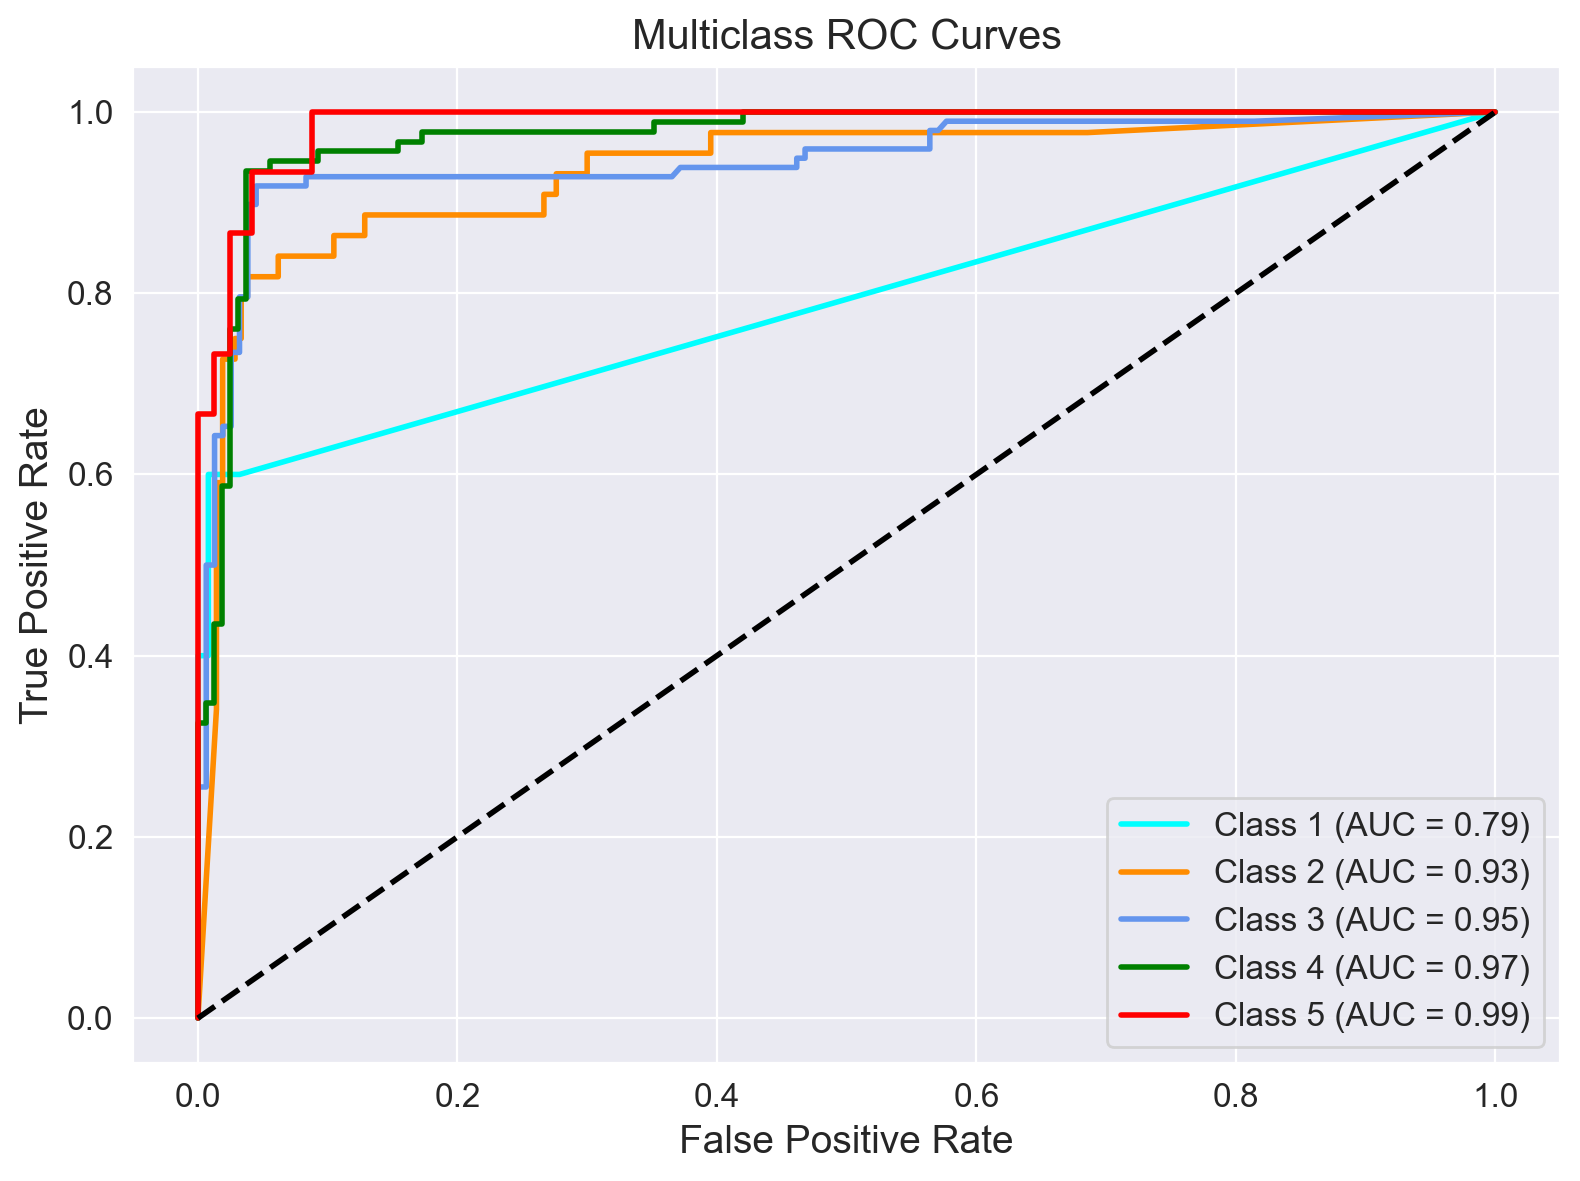

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizing the output labels
classes = np.unique(y_test_smote)
y_test_bin = label_binarize(y_test_smote, classes=classes)
n_classes = y_test_bin.shape[1]

# Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Getting the probabilistic predictions for logistic regression
y_proba = rs_lr.best_estimator_.predict_proba(final_test_df)
roc_auc = roc_auc_score(y_test_smote, y_proba, multi_class='ovr', average='weighted')
print(f"Weighted ROC-AUC Score: {roc_auc:.4f}")

Weighted ROC-AUC Score: 0.8938


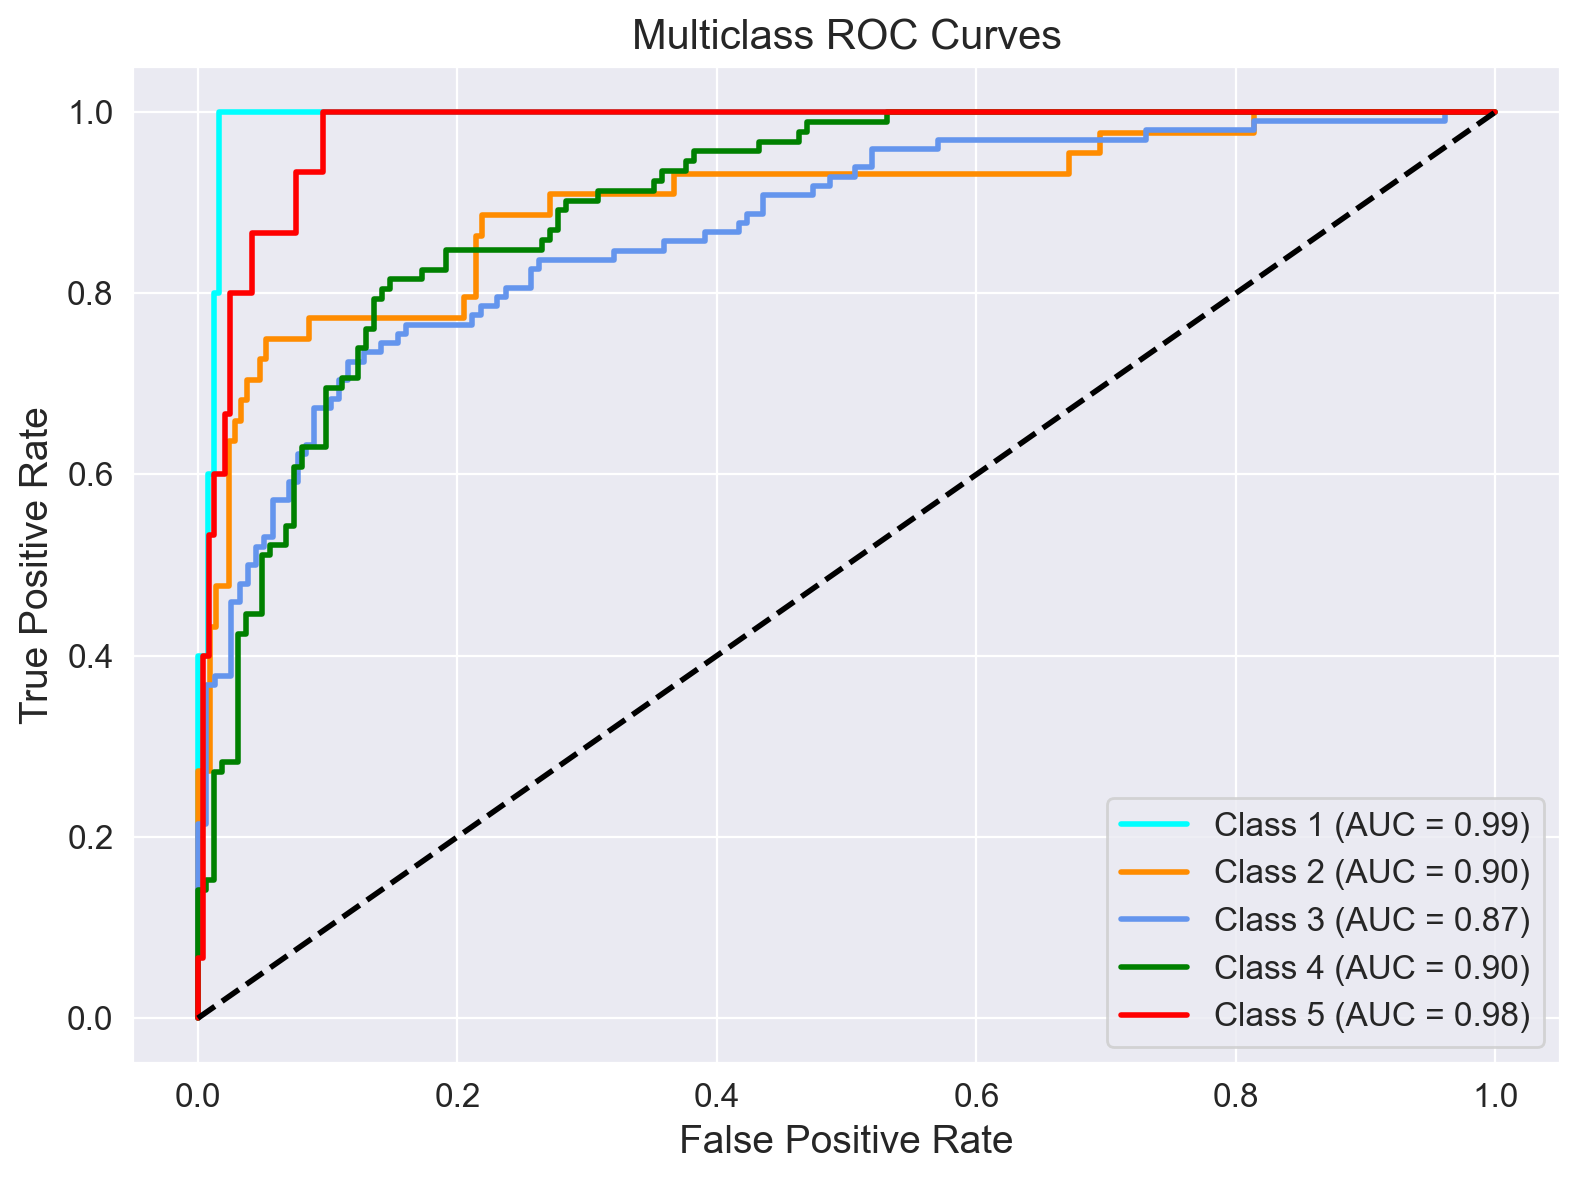

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizing the output labels
classes = np.unique(y_test_smote)
y_test_bin = label_binarize(y_test_smote, classes=classes)
n_classes = y_test_bin.shape[1]

# Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Getting the probabilistic predictions for K-neighbors classifier
y_proba = rs_kn.best_estimator_.predict_proba(final_test_df)
roc_auc = roc_auc_score(y_test_smote, y_proba, multi_class='ovr', average='weighted')
print(f"Weighted ROC-AUC Score: {roc_auc:.4f}")

Weighted ROC-AUC Score: 0.8858


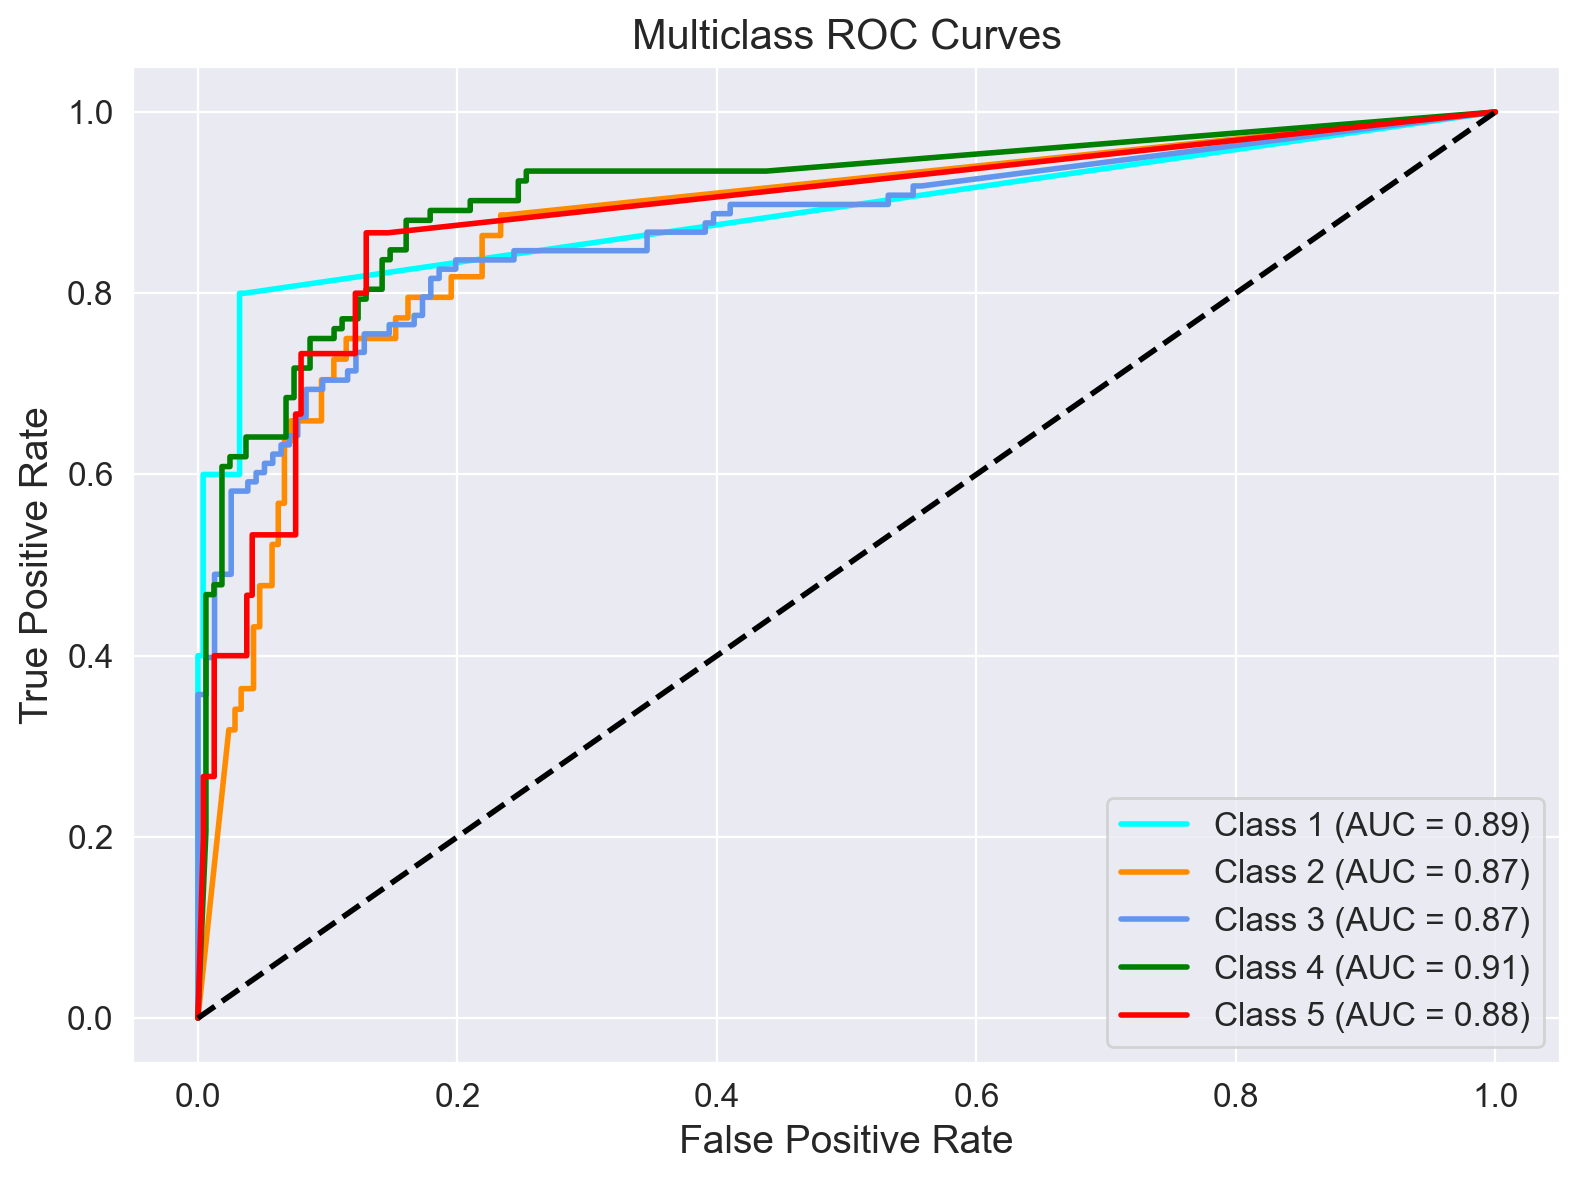

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizing the output labels
classes = np.unique(y_test_smote)
y_test_bin = label_binarize(y_test_smote, classes=classes)
n_classes = y_test_bin.shape[1]

# Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Getting the probabilistic predictions for Decision Tree
y_proba = rs_dt.best_estimator_.predict_proba(final_test_df)
roc_auc = roc_auc_score(y_test_smote, y_proba, multi_class='ovr', average='weighted')
print(f"Weighted ROC-AUC Score: {roc_auc:.4f}")

Weighted ROC-AUC Score: 0.9081


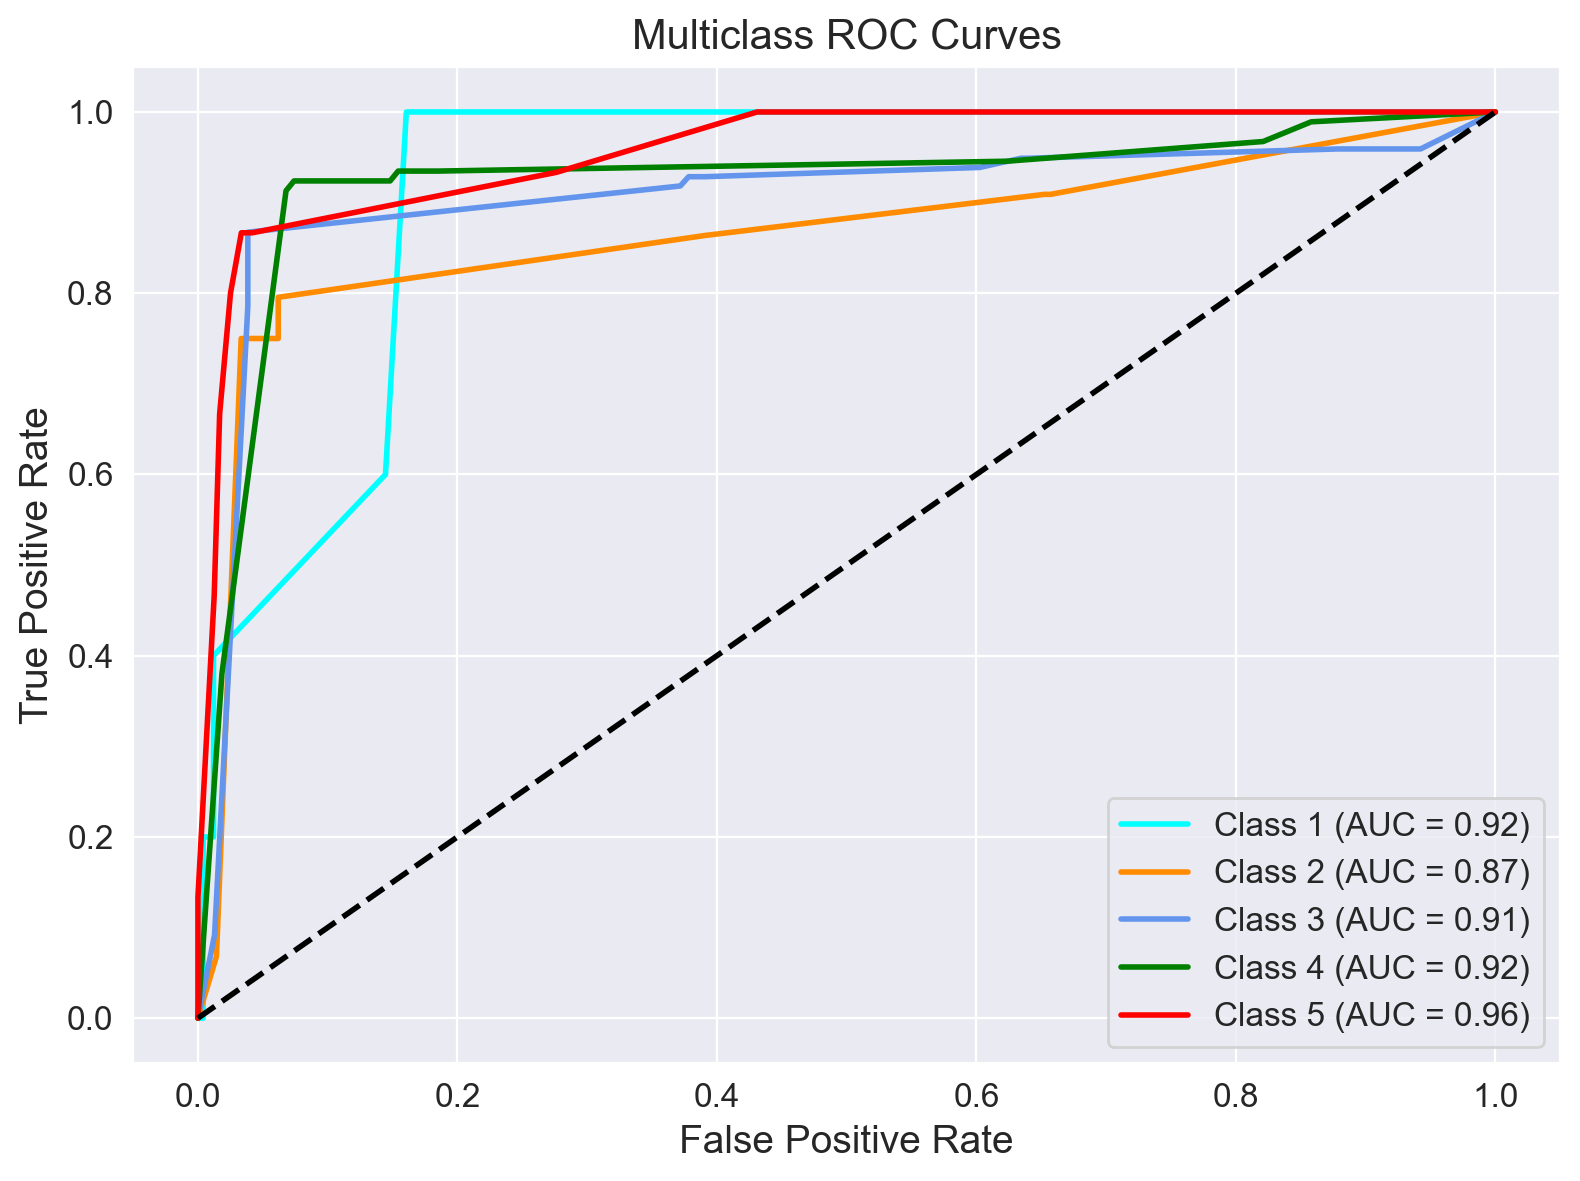

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizing the output labels
classes = np.unique(y_test_smote)
y_test_bin = label_binarize(y_test_smote, classes=classes)
n_classes = y_test_bin.shape[1]

# Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Getting the probabilistic predictions for Adaboost
y_proba = rs_ada.best_estimator_.predict_proba(final_test_df)
roc_auc = roc_auc_score(y_test_smote, y_proba, multi_class='ovr', average='weighted')
print(f"Weighted ROC-AUC Score: {roc_auc:.4f}")

Weighted ROC-AUC Score: 0.9563


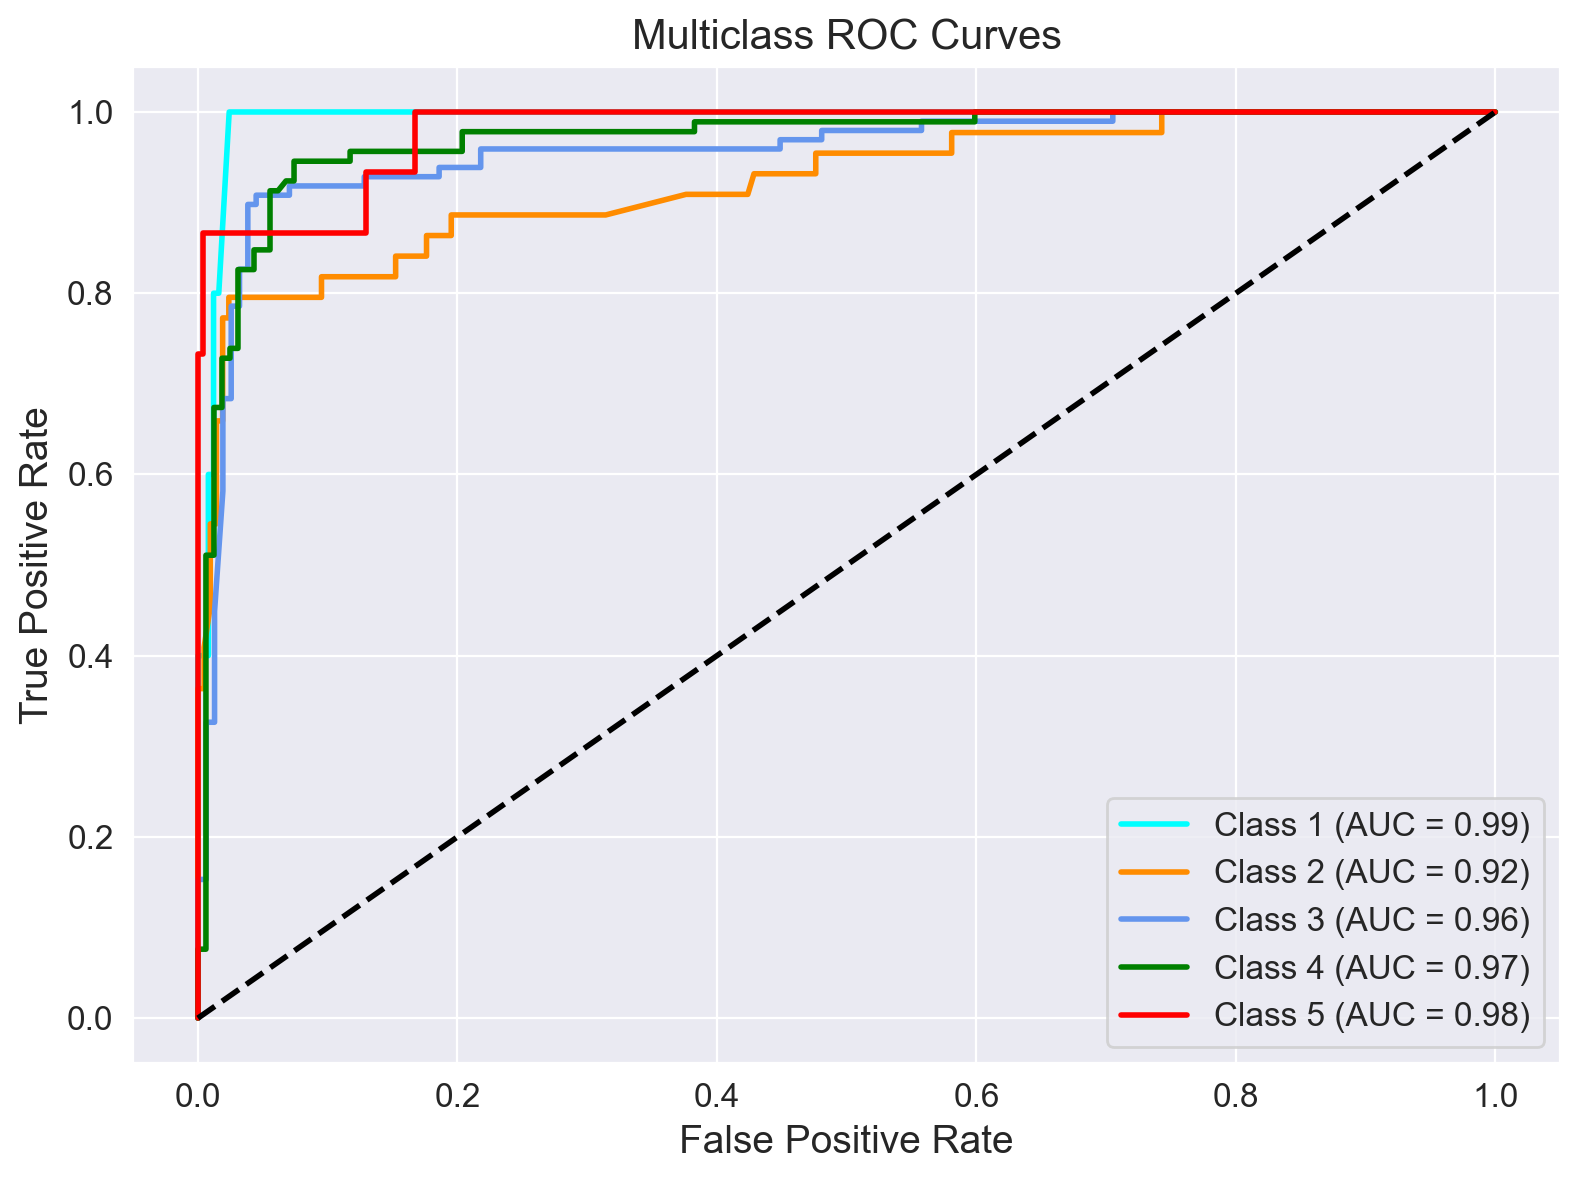

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizing the output labels
classes = np.unique(y_test_smote)
y_test_bin = label_binarize(y_test_smote, classes=classes)
n_classes = y_test_bin.shape[1]

# Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Getting the probabilistic predictions for Adaboost
y_proba = rs_svc.best_estimator_.predict_proba(final_test_df)
roc_auc = roc_auc_score(y_test_smote, y_proba, multi_class='ovr', average='weighted')
print(f"Weighted ROC-AUC Score: {roc_auc:.4f}")

Weighted ROC-AUC Score: 0.9281


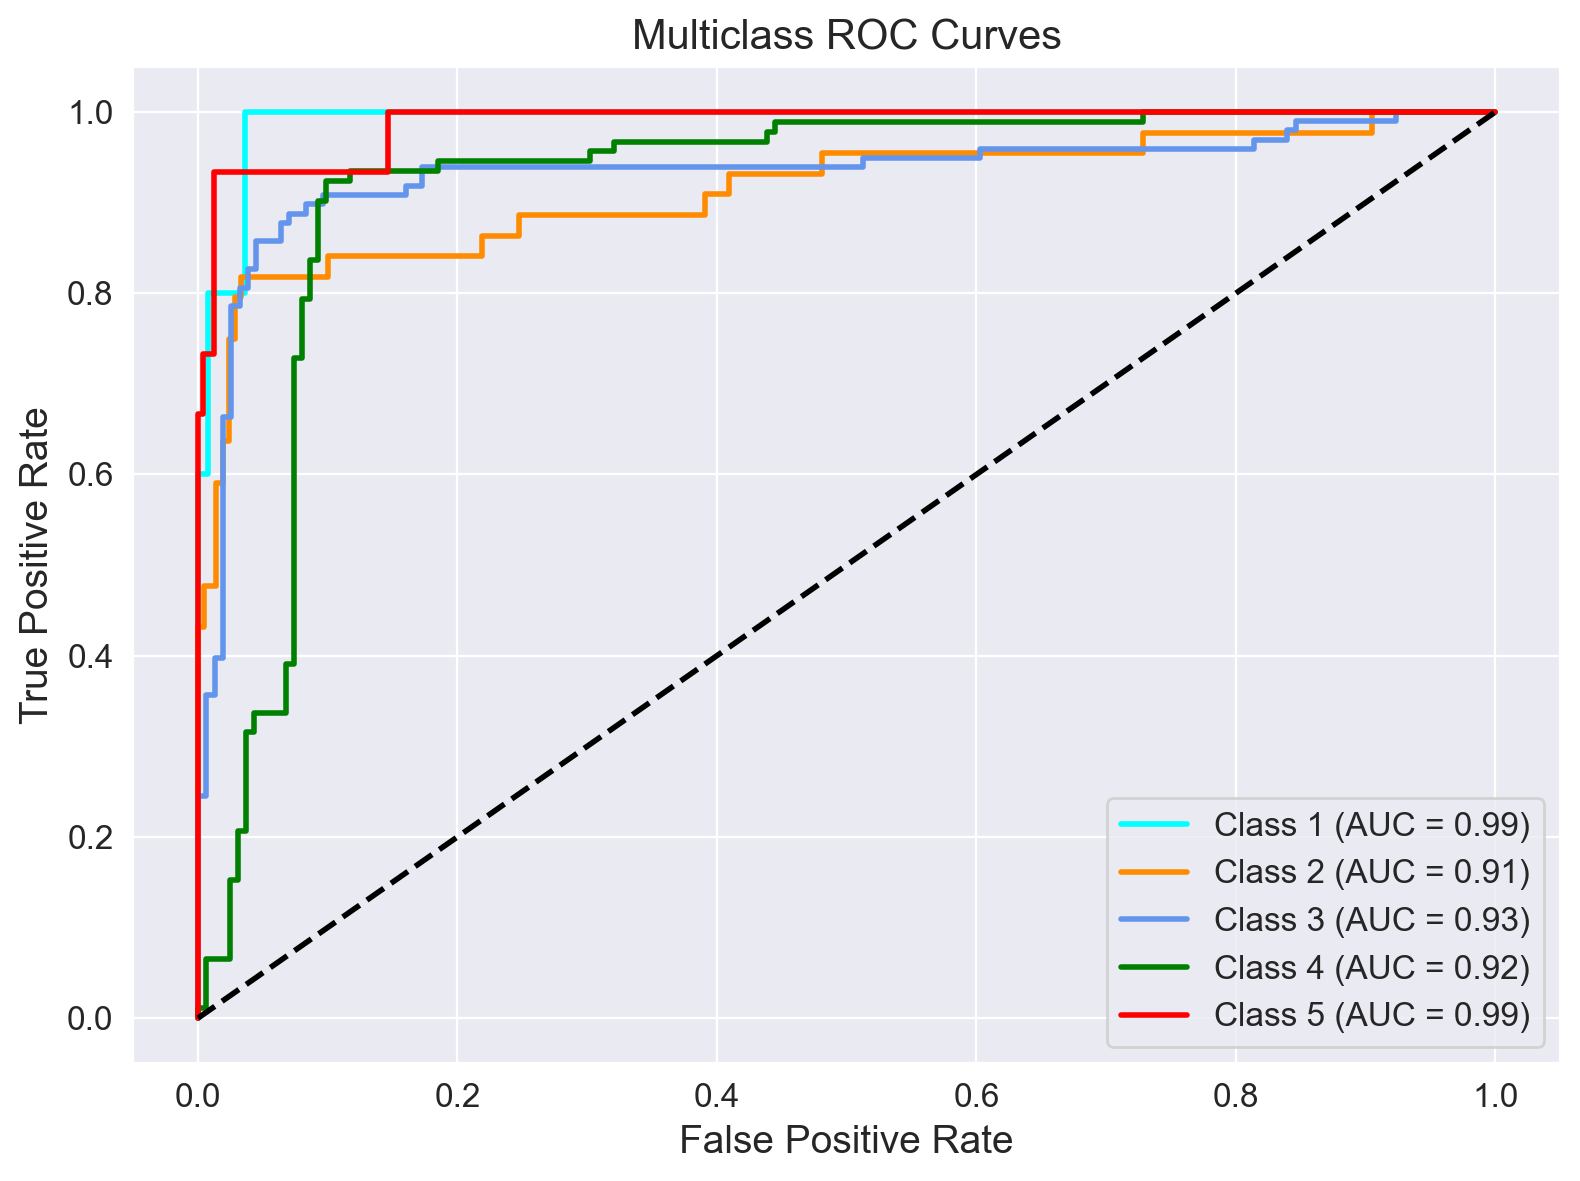

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizing the output labels
classes = np.unique(y_test_smote)
y_test_bin = label_binarize(y_test_smote, classes=classes)
n_classes = y_test_bin.shape[1]

# Computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


* From the roc-auc score and the roc curve, we can interpret that the model is **very good at separating each class in the One vs Rest(OvR) setup**
* Weighted average score is very high indicating that the imbalanced classes are being handled well, High TPR and less FPR across all classes

## Explainability

We will use **ELI5(Explain Like I'm 5)**, as the Explainable AI here, as it is model-agnostic and it measures overall feature impact by removing each feature iteratively, and measuring the performance of the model, which indicates how important a feature is in model predictions.

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# Fitting permutation importance on the training set
perm = PermutationImportance(rs_rf.best_estimator_, random_state=42).fit(final_train_df, y_train_smote)

# Extracting feature weights into a readable DataFrame
weights_df = eli5.explain_weights_df(perm, feature_names=final_train_df.columns.tolist())

# View top 20 features
weights_df.head(20)


feature    weight       std
0      KTAS_RN  0.712288  0.013315
1     NRS_pain  0.030026  0.001364
2       svd_40  0.026221  0.002367
3          SBP  0.025296  0.001733
4        svd_2  0.025090  0.001432
5           BT  0.007404  0.000617
6        svd_6  0.007301  0.000385
7       svd_10  0.007095  0.002215
8          Age  0.006787  0.001190
9          Sex  0.004010  0.001276
10  Saturation  0.003290  0.000524
11       svd_1  0.002879  0.001059
12      svd_36  0.002776  0.000954
13      svd_45  0.002571  0.000650
14      svd_17  0.002571  0.000325
15      svd_12  0.002468  0.001190
16       svd_8  0.002468  0.000885
17      svd_35  0.002365  0.000252
18      svd_48  0.002365  0.000524
19       svd_3  0.002262  0.000524

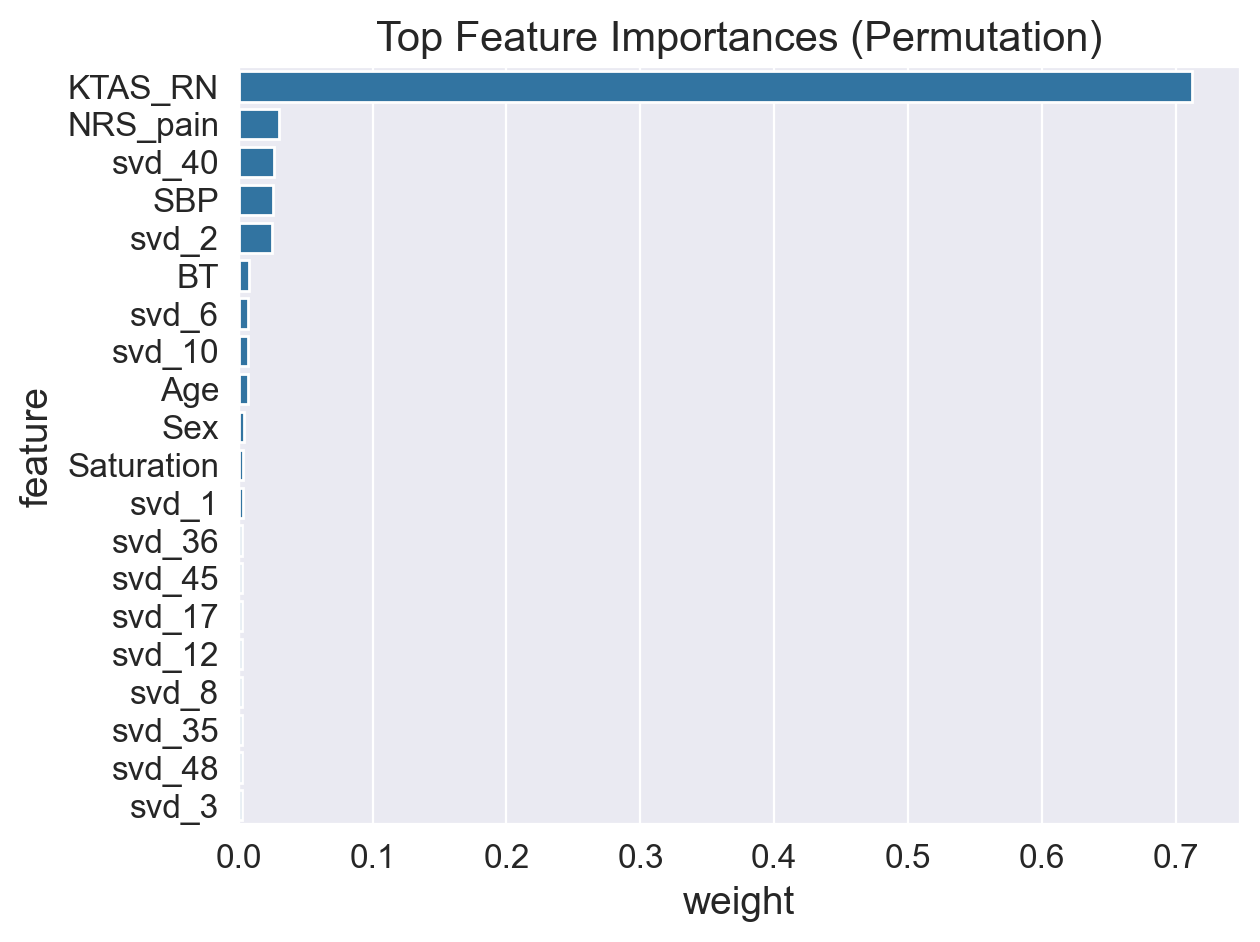

In [ ]:
# Plotting top 20 features
top_n = 20
sns.barplot(
    x='weight', y='feature',
    data=weights_df.iloc[:top_n].sort_values('weight', ascending=False)
)
plt.title("Top Feature Importances (Permutation)")
plt.tight_layout()
plt.show()


In [ ]:
# Fitting permutation importance on the test set
perm = PermutationImportance(rs_rf.best_estimator_, random_state=42).fit(final_test_df, y_test_smote)

# Extracting feature weights into a readable DataFrame
weights_df = eli5.explain_weights_df(perm, feature_names=final_test_df.columns.tolist())

# View top 20 features
weights_df.head(20)

feature    weight       std
0      KTAS_RN  0.525197  0.024974
1     NRS_pain  0.058268  0.009115
2          SBP  0.008661  0.003857
3       svd_13  0.006299  0.001929
4        Group  0.005512  0.005340
5       svd_15  0.005512  0.001929
6          Age  0.004724  0.001575
7           BT  0.003937  0.002490
8   Saturation  0.003937  0.000000
9        svd_1  0.003937  0.002490
10      svd_40  0.003937  0.000000
11       svd_3  0.003937  0.000000
12          RR  0.003150  0.001575
13      svd_18  0.003150  0.001575
14      svd_10  0.003150  0.002946
15       svd_9  0.002362  0.001929
16      svd_14  0.002362  0.001929
17      svd_20  0.002362  0.001929
18      svd_37  0.002362  0.001929
19      svd_45  0.002362  0.001929

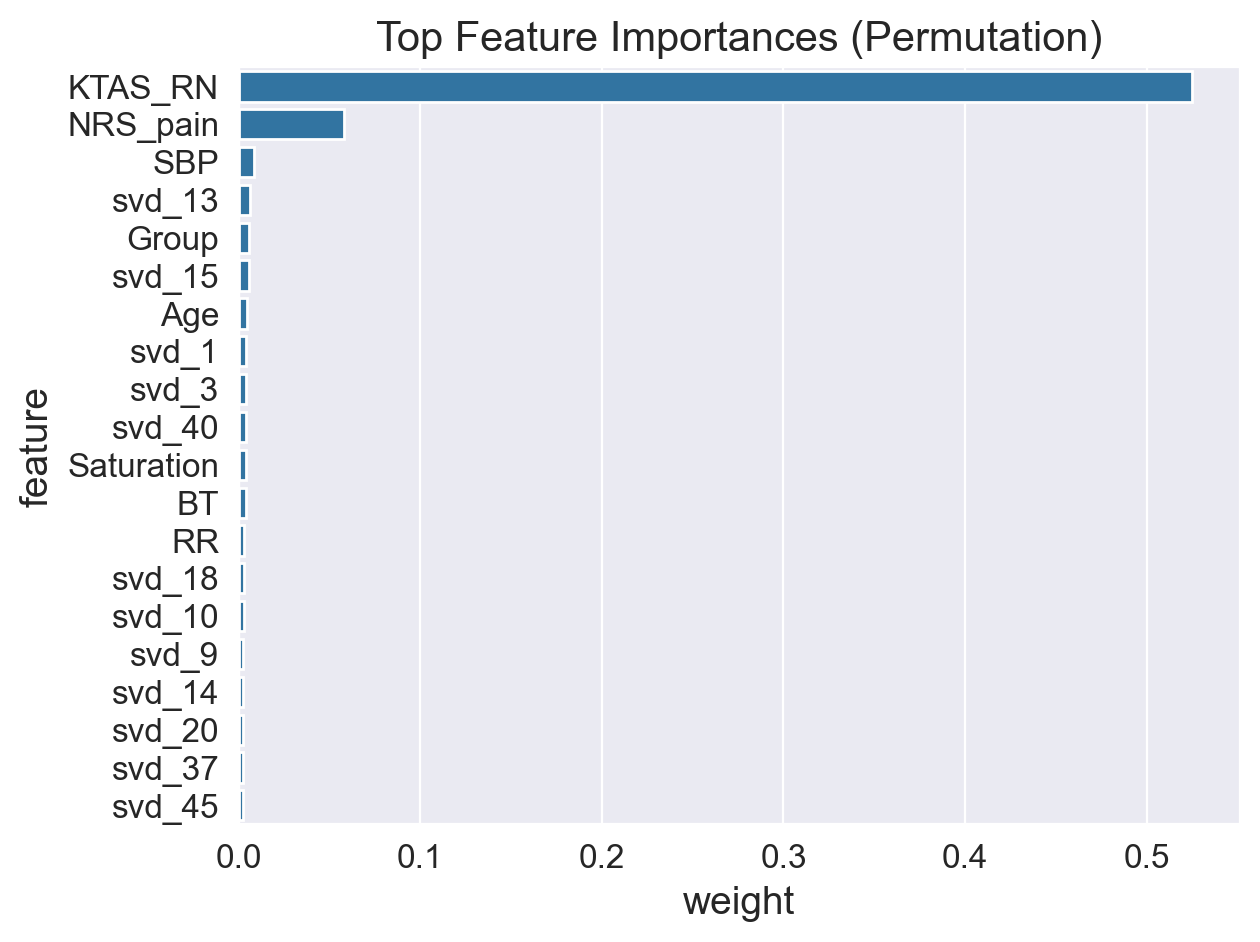

In [ ]:
# Plot top N features
top_n = 20
sns.barplot(
    x='weight', y='feature',
    data=weights_df.iloc[:top_n].sort_values('weight', ascending=False)
)
plt.title("Top Feature Importances (Permutation)")
plt.tight_layout()
plt.show()

* As we can see, KTAS_RN, Error_group, mistriage are the main important features on which the model makes successful predictions.
* It is the same on the training and test set, so this confirms there is no problem of overfitting and the model is stable.

In [ ]:
# Model
with open('ed_model.pkl','wb') as f:
    pickle.dump(rs_rf.best_estimator_,f)
# Scaler
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)
# Dimensionality reduction
with open('truncated-svd.pkl','wb') as f:
    pickle.dump(svd,f)
